# Stacked Machine Learning

In [1]:
## IMPORTANT !

# In the first order need to set the number of CPU 
# for calculation before launching (depends on computer's number of cores)
n_jobs= 30

### Load libraries

In [2]:
#libraries
import pandas as pd
import numpy as np
import os
import sys
import shutil
import glob
import joblib
import warnings
from datetime import date, datetime

from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import LeavePGroupsOut
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr
import scipy.stats as st

from nilearn import image as nli
from nilearn import plotting

#from mne.viz import plot_connectivity_circle
from mne_connectivity.viz import plot_connectivity_circle

import matplotlib.patches as mpatches

### Path to the tables folder

##### path

In [3]:
#path to folders with prepared tables
path_tab_sp = '/media/hcs-psy-narun/Nesi/HCP_YA_Cognitive_Predicition/ML_ready_tables_residuals_RACE_folds/'
print(sorted(os.listdir(path_tab_sp)))

['Fold_0', 'Fold_1', 'Fold_2', 'Fold_3', 'Fold_4', 'Fold_5', 'Fold_6', 'Fold_7']


In [4]:
#path to folder with results
path_tab_res = '/media/hcs-psy-narun/Alina_results/Alina3/race/'

In [5]:
path_tab_res_flat = '/media/hcs-psy-narun/Alina_results/Alina3/flat/withRace_tables/'

In [7]:
os.mkdir('/media/hcs-psy-narun/Alina_results/Alina3/raceset_outputs/')

In [8]:
path_out = '/media/hcs-psy-narun/Alina_results/Alina3/raceset_outputs/'

#### load results table

In [9]:
#load results
dct_results={}
for i in sorted(glob.glob(path_tab_res+'tables_*')):
    dct_results[i.split('/')[-1].split('.')[0].split('_')[1]] = pd.read_csv(i, index_col=0)

In [10]:
#load results for flat
#dct_results_flat={}
for i in sorted(glob.glob(path_tab_res_flat+'tables_*')):
    dct_results['flat+'+('_'.join(i.split('/')[-1].split('.')[0].split('_')[1:3]))] = pd.read_csv(i, index_col=0)

In [11]:
[i for i in dct_results.keys()]

['eNet+eNet',
 'eNet+rf',
 'eNet+svr',
 'eNet+xgb',
 'eNet',
 'rf+eNet',
 'rf+rf',
 'rf+svr',
 'rf+xgb',
 'rf',
 'svr+eNet',
 'svr+rf',
 'svr+svr',
 'svr+xgb',
 'svr',
 'xgb+eNet',
 'xgb+rf',
 'xgb+svr',
 'xgb+xgb',
 'xgb',
 'flat+eNet_all',
 'flat+eNet_non-task',
 'flat+eNet_task',
 'flat+eNet_top-task',
 'flat+rf_all',
 'flat+rf_non-task',
 'flat+rf_task',
 'flat+rf_top-task',
 'flat+svr_all',
 'flat+svr_non-task',
 'flat+svr_task',
 'flat+svr_top-task',
 'flat+xgb_all',
 'flat+xgb_non-task',
 'flat+xgb_task',
 'flat+xgb_top-task']

In [12]:
#indexes for subject
dct_indx = {}
for i in sorted(glob.glob(path_tab_sp+'Fold_*/target_y_test.csv')):
    dct_indx[i.split('/')[-2]] = pd.read_csv(i, index_col=0, header=None)
    
i, x, z = dct_indx['Fold_0'].index.values, dct_indx['Fold_0'][1].values, np.full(len(dct_indx['Fold_0'].index), 0)
#dct_indx_concat={}
for key in sorted(dct_indx.keys())[1:]:
    i = np.concatenate((i, dct_indx[key].index.values) , axis=None)
    x = np.concatenate((x, dct_indx[key][1].values) , axis=None)
    z = np.concatenate((z, np.full(len(dct_indx[key].index), key.split('_')[-1])) , axis=None)

df_indx = pd.DataFrame({'sID': i,
                     'y_real': x,
                     'fold':z})
df_indx.index=df_indx['sID']
#display(df_indx)

In [13]:
#organize in a bit different way
for key in dct_results.keys():
    #print(key)
    dct_results[key].index = df_indx['sID'].values
    if 'flat' not in key:
        dct_results[key] = dct_results[key].drop(['y_true', 'fold'], axis=1)
        dct_results[key] = pd.concat([dct_results[key], df_indx[['y_real', 'fold']]], axis=1)
    if 'flat' in key:
        dct_results[key] = dct_results[key].drop(['y_true'], axis=1)
        dct_results[key] = pd.concat([dct_results[key], df_indx[['y_real', 'fold']]], axis=1)
        dct_results[key].columns = ['all', 'y_real', 'fold']
    #display(dct_results[key])

In [14]:
key_with_flat = [i for i in dct_results.keys() if 'flat' in i]


for newkey in ['flat+eNet', 'flat+rf', 'flat+svr', 'flat+xgb']:
    dct_results[newkey] = pd.DataFrame({'all':dct_results[newkey+'_all']['all'],
                                    'task':dct_results[newkey+'_task']['all'], 
                                    'non-task':dct_results[newkey+'_non-task']['all'],
                                    'top-task':dct_results[newkey+'_top-task']['all'],
                                    'y_real':dct_results[newkey+'_top-task']['y_real'],
                                    'fold':dct_results[newkey+'_top-task']['fold']}, 
                                   index=dct_results[newkey+'_top-task'].index)
    
for k in key_with_flat:
    del dct_results[k]

In [15]:
[i for i in dct_results.keys()]

['eNet+eNet',
 'eNet+rf',
 'eNet+svr',
 'eNet+xgb',
 'eNet',
 'rf+eNet',
 'rf+rf',
 'rf+svr',
 'rf+xgb',
 'rf',
 'svr+eNet',
 'svr+rf',
 'svr+svr',
 'svr+xgb',
 'svr',
 'xgb+eNet',
 'xgb+rf',
 'xgb+svr',
 'xgb+xgb',
 'xgb',
 'flat+eNet',
 'flat+rf',
 'flat+svr',
 'flat+xgb']

# Bootstraping

In [16]:
#initial indexing
bindex = dct_results['eNet'].index

#dicts for results
dct_bootstrap_r2 = {}
dct_bootstrap_mse = {}
dct_bootstrap_mae = {}
dct_bootstrap_cor = {}
dct_bootstrap_MEAN = {}

#add second layer to output dicts
for KEY in dct_results.keys():
    dct_bootstrap_r2[KEY] = {}
    dct_bootstrap_mse[KEY] = {}
    dct_bootstrap_mae[KEY] = {}
    dct_bootstrap_cor[KEY] = {}

#bootstrapping
i=0
while i<5000: #number of trials
    #shuffled index 
    bbindex = resample(bindex, replace=True, n_samples=len(bindex), random_state=i) 
    
    #apply shuffled index to all tables
    for KEY in dct_results.keys():
        
        data = dct_results[KEY].reindex(index=bbindex)
        
        #calculate indexes
        cor, r2, mse, mae, cols = [], [], [], [], []
        for col in data.columns[0:-2]:
            corr, _ = pearsonr(data['y_real'], data[col])
            cor += [corr]
            r2 += [r2_score(data['y_real'], data[col])]
            mse += [mean_squared_error(data['y_real'], data[col])]
            mae += [mean_absolute_error(data['y_real'], data[col])]
            cols +=[col]
        # series of indexes for #i iteration
        dct_bootstrap_r2[KEY][i] = pd.Series(r2, index=cols)
        dct_bootstrap_mse[KEY][i] = pd.Series(mse, index=cols)
        dct_bootstrap_mae[KEY][i] = pd.Series(mae, index=cols)
        dct_bootstrap_cor[KEY][i] = pd.Series(cor, index=cols)
  
    i+=1
    
#reformating second layer of dicts into tables    
for KEY in dct_results.keys():
    dct_bootstrap_r2[KEY] = pd.DataFrame(dct_bootstrap_r2[KEY]).T
    dct_bootstrap_mse[KEY] = pd.DataFrame(dct_bootstrap_mse[KEY]).T
    dct_bootstrap_mae[KEY] = pd.DataFrame(dct_bootstrap_mae[KEY]).T
    dct_bootstrap_cor[KEY] = pd.DataFrame(dct_bootstrap_cor[KEY]).T
    dct_bootstrap_MEAN[KEY] = pd.DataFrame({'r2': pd.DataFrame(dct_bootstrap_r2[KEY]).mean(),
                                            'mse': pd.DataFrame(dct_bootstrap_mse[KEY]).mean(),
                                            'mae': pd.DataFrame(dct_bootstrap_mae[KEY]).mean(),
                                            'cor': pd.DataFrame(dct_bootstrap_cor[KEY]).mean()})
    print(KEY)
    print('Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds')
    display(dct_bootstrap_MEAN[KEY].sort_values(by='r2', ascending=False))


eNet+eNet
Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds


,r2,mse,mae,cor
all,0.260784,121.663433,8.938527,0.512824
task,0.249836,123.474813,8.962319,0.502622
top-task,0.243884,124.448854,8.999203,0.496003
non-task,0.013206,162.466489,10.300889,0.122328


eNet+rf
Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds


,r2,mse,mae,cor
all,0.234039,126.070738,9.097538,0.488644
top-task,0.231111,126.564856,9.064434,0.487786
task,0.215090,129.200794,9.126241,0.466631
non-task,0.019996,161.347025,10.264792,0.145715


eNet+svr
Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds


,r2,mse,mae,cor
all,0.244761,124.282886,8.991078,0.498624
top-task,0.234946,125.904276,9.076183,0.489022
task,0.221802,128.068291,9.144208,0.476694
non-task,-0.001705,164.931876,10.299112,0.106090


eNet+xgb
Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds


,r2,mse,mae,cor
top-task,0.234109,126.048002,8.964761,0.486083
all,0.229449,126.813193,9.091861,0.480696
task,0.216213,128.991714,9.009308,0.470229
non-task,-0.018158,167.601829,10.528410,0.101685


eNet
Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds


,r2,mse,mae,cor
wm,0.192552,132.914235,9.203612,0.440671
lan,0.106989,147.008753,9.763478,0.329029
rel,0.057992,155.085793,9.978084,0.244969
soc,0.034503,158.972850,10.138144,0.192676
surf,0.025097,160.508222,10.254671,0.162896
mot,0.023595,160.760745,10.233819,0.157885
emo,0.020818,161.221378,10.225372,0.164836
VolBrain,0.007954,163.335767,10.341791,0.097633
cort,0.001536,164.403398,10.299098,0.058081
subc,0.000369,164.584702,10.392650,0.067863


rf+eNet
Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds


,r2,mse,mae,cor
all,0.210960,129.868149,9.201185,0.460751
top-task,0.200542,131.589585,9.228718,0.449347
task,0.199862,131.701024,9.246847,0.448526
non-task,0.012468,162.587677,10.299656,0.126042


rf+rf
Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds


,r2,mse,mae,cor
all,0.196052,132.333697,9.276188,0.449155
top-task,0.184402,134.254715,9.304336,0.433520
task,0.178863,135.165797,9.341487,0.424981
non-task,0.017525,161.755868,10.266237,0.138846


rf+svr
Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds


,r2,mse,mae,cor
all,0.199841,131.696504,9.238645,0.453147
top-task,0.195246,132.460692,9.235843,0.446692
task,0.192607,132.884258,9.219725,0.446107
non-task,0.002693,164.198168,10.301684,0.129942


rf+xgb
Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds


,r2,mse,mae,cor
top-task,0.192467,132.905300,9.243652,0.443146
task,0.173255,136.065316,9.362252,0.422795
all,0.168246,136.878567,9.471934,0.418407
non-task,-0.017562,167.501462,10.427253,0.123644


rf
Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds


,r2,mse,mae,cor
wm,0.142450,141.171986,9.531496,0.380108
lan,0.094164,149.134693,9.830632,0.317806
rel,0.049859,156.425015,10.074064,0.228370
soc,0.030679,159.591651,10.142745,0.178851
emo,0.027395,160.138269,10.182534,0.169173
surf,0.018693,161.559076,10.260621,0.144079
mot,0.012195,162.640066,10.320500,0.116295
VolBrain,0.011601,162.730004,10.335551,0.115148
subc,0.011120,162.818085,10.326090,0.111818
gam,-0.001049,164.825116,10.351098,0.048717


svr+eNet
Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds


,r2,mse,mae,cor
all,0.210391,129.947958,9.204623,0.463357
top-task,0.209268,130.146853,9.128377,0.459326
task,0.207466,130.438991,9.176275,0.458474
non-task,0.003544,164.056366,10.331801,0.102665


svr+rf
Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds


,r2,mse,mae,cor
all,0.198109,131.992470,9.249711,0.446410
top-task,0.193976,132.674220,9.194803,0.441856
task,0.192600,132.900920,9.239437,0.440288
non-task,0.000255,164.599446,10.370608,0.080825


svr+svr
Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds


,r2,mse,mae,cor
top-task,0.198102,131.988095,9.127341,0.454501
all,0.189288,133.420688,9.220402,0.447427
task,0.170408,136.525141,9.305647,0.439784
non-task,-0.020545,168.028708,10.423508,0.054939


svr+xgb
Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds


,r2,mse,mae,cor
top-task,0.163378,137.688032,9.271311,0.420715
all,0.156160,138.872427,9.439448,0.411323
task,0.153480,139.309874,9.380615,0.417896
non-task,-0.062289,174.874162,10.631325,0.030709


svr
Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds


,r2,mse,mae,cor
wm,0.153709,139.303512,9.371355,0.404478
lan,0.085675,150.516566,9.786370,0.314404
rel,0.050654,156.281928,10.000079,0.247922
soc,0.018920,161.515204,10.195249,0.177532
surf,0.018888,161.537913,10.193860,0.162522
mot,0.018456,161.597761,10.248951,0.165248
emo,-0.006621,165.727649,10.271592,0.132368
cort,-0.012623,166.737549,10.327615,0.028124
rest-pca75,-0.013901,166.941999,10.398379,0.047572
VolBrain,-0.016357,167.334005,10.431551,0.063317


xgb+eNet
Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds


,r2,mse,mae,cor
task,0.170186,136.589571,9.417155,0.414295
top-task,0.168454,136.870366,9.385581,0.412972
all,0.163086,137.752297,9.482168,0.406374
non-task,-0.002731,165.088769,10.400774,0.083457


xgb+rf
Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds


,r2,mse,mae,cor
top-task,0.150487,139.834507,9.405190,0.390752
task,0.137864,141.927327,9.482292,0.373483
all,0.130409,143.142044,9.530400,0.365810
non-task,0.005043,163.805590,10.377273,0.110368


xgb+svr
Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds


,r2,mse,mae,cor
top-task,0.149796,139.936486,9.397667,0.399744
all,0.142525,141.125351,9.541198,0.394013
task,0.140234,141.503868,9.534605,0.393252
non-task,-0.031060,169.756944,10.511647,0.045941


xgb+xgb
Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds


,r2,mse,mae,cor
top-task,0.158300,138.536402,9.372108,0.404836
task,0.134985,142.380797,9.519335,0.376894
all,0.133824,142.570367,9.552979,0.375483
non-task,-0.019174,167.775802,10.477716,0.112910


xgb
Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds


,r2,mse,mae,cor
wm,0.101607,147.879211,9.679543,0.334730
lan,0.078399,151.713840,9.809920,0.286694
rel,0.033631,159.089376,10.157481,0.204805
soc,0.028288,159.988035,10.151313,0.171855
subc,0.014953,162.183407,10.312727,0.132366
emo,0.010244,162.956961,10.281297,0.133629
VolBrain,-0.000513,164.720525,10.414079,0.087670
surf,-0.004209,165.322489,10.391471,0.104727
gam,-0.007637,165.904095,10.358053,0.065780
rest-pca75,-0.015528,167.205500,10.426533,0.010926


flat+eNet
Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds


,r2,mse,mae,cor
all,0.257780,122.153058,8.996938,0.509827
top-task,0.256514,122.370729,8.963638,0.508735
task,0.247638,123.832159,9.031308,0.501415
non-task,0.014770,162.193135,10.292645,0.151016


flat+rf
Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds


,r2,mse,mae,cor
top-task,0.182933,134.508452,9.364477,0.440375
all,0.171709,136.358411,9.426682,0.435771
task,0.166741,137.177771,9.440735,0.425996
non-task,0.027314,160.137703,10.236085,0.169292


flat+svr
Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds


,r2,mse,mae,cor
all,0.251705,123.129443,8.966828,0.507486
top-task,0.250063,123.418875,8.898880,0.505561
task,0.245113,124.225746,8.966129,0.499855
non-task,0.019213,161.470148,10.288796,0.146717


flat+xgb
Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds


,r2,mse,mae,cor
top-task,0.217269,128.834623,9.118439,0.468437
task,0.204788,130.895882,9.188011,0.456683
all,0.185698,134.031347,9.310506,0.432282
non-task,0.014117,162.310341,10.298698,0.139178


In [17]:
#confidence intervals for bootstrap, R2 ONLY!
print('R2 Confidence Intervals')
CI_dct_bootstrap_r2= {}
for KEY in dct_bootstrap_r2.keys():
    dataset = dct_bootstrap_r2[KEY]

    CI1, CI2, colss = [],[], []
    for col in dataset.columns:
        CI1 += [(st.t.interval(alpha=0.95, df=len(dataset[col])-1, loc=np.mean(dataset[col]), scale=np.std(dataset[col])))[0]]
        CI2 += [(st.t.interval(alpha=0.95, df=len(dataset[col])-1, loc=np.mean(dataset[col]), scale=np.std(dataset[col])))[1]]
        colss += [col]
    df_CI = pd.DataFrame({'CI1':CI1, 'CI2':CI2}, index=colss)#.sort_values(by='CI1', ascending=True)
    CI_dct_bootstrap_r2[KEY]=df_CI
    print(KEY)
    display(df_CI)

R2 Confidence Intervals
eNet+eNet


,CI1,CI2
all,0.215320,0.306247
task,0.205331,0.294342
non-task,-0.005175,0.031587
top-task,0.199024,0.288744


eNet+rf


,CI1,CI2
all,0.192265,0.275813
task,0.171218,0.258962
non-task,0.000185,0.039806
top-task,0.190802,0.271420


eNet+svr


,CI1,CI2
all,0.192746,0.296775
task,0.167396,0.276208
non-task,-0.023911,0.020501
top-task,0.182630,0.287263


eNet+xgb


,CI1,CI2
all,0.180777,0.278122
task,0.161280,0.271147
non-task,-0.054007,0.017691
top-task,0.182217,0.286000


eNet


,CI1,CI2
wm,0.148475,0.236629
lan,0.064468,0.149510
rel,0.023219,0.092764
mot,0.002547,0.044643
emo,-0.009853,0.051489
soc,0.016393,0.052613
gam,-0.007681,0.002629
rest-pca75,-0.019514,0.010713
surf,0.006538,0.043657
VolBrain,-0.006449,0.022357


rf+eNet


,CI1,CI2
all,0.163897,0.258024
task,0.153190,0.246533
non-task,-0.009782,0.034718
top-task,0.153519,0.247565


rf+rf


,CI1,CI2
all,0.156593,0.235511
task,0.135436,0.222290
non-task,-0.002419,0.037469
top-task,0.143746,0.225057


rf+svr


,CI1,CI2
all,0.151572,0.248110
task,0.139827,0.245387
non-task,-0.026162,0.031547
top-task,0.146596,0.243896


rf+xgb


,CI1,CI2
all,0.114822,0.221670
task,0.120731,0.225778
non-task,-0.056069,0.020946
top-task,0.141088,0.243847


rf


,CI1,CI2
wm,0.101327,0.183573
lan,0.063976,0.124352
rel,0.017118,0.082600
mot,-0.002431,0.026822
emo,0.004983,0.049808
soc,0.008053,0.053305
gam,-0.014318,0.012219
rest-pca75,-0.016959,0.001127
surf,-0.002770,0.040156
VolBrain,-0.006329,0.029530


svr+eNet


,CI1,CI2
all,0.156697,0.264085
task,0.154284,0.260649
non-task,-0.019808,0.026896
top-task,0.157430,0.261105


svr+rf


,CI1,CI2
all,0.152247,0.243972
task,0.143994,0.241205
non-task,-0.018762,0.019273
top-task,0.146073,0.241879


svr+svr


,CI1,CI2
all,0.131658,0.246918
task,0.103686,0.237130
non-task,-0.048167,0.007076
top-task,0.143961,0.252243


svr+xgb


,CI1,CI2
all,0.098139,0.214181
task,0.090333,0.216626
non-task,-0.100137,-0.024441
top-task,0.101500,0.225257


svr


,CI1,CI2
wm,0.102641,0.204776
lan,0.036104,0.135246
rel,0.009452,0.091855
mot,-0.011595,0.048507
emo,-0.042801,0.029560
soc,-0.016031,0.053871
gam,-0.050499,-0.001194
rest-pca75,-0.034479,0.006677
surf,-0.006495,0.044270
VolBrain,-0.041697,0.008983


xgb+eNet


,CI1,CI2
all,0.115591,0.210581
task,0.125627,0.214745
non-task,-0.024471,0.019009
top-task,0.120077,0.216831


xgb+rf


,CI1,CI2
all,0.082825,0.177993
task,0.094121,0.181608
non-task,-0.018247,0.028333
top-task,0.102063,0.198910


xgb+svr


,CI1,CI2
all,0.087415,0.197634
task,0.084663,0.195805
non-task,-0.059216,-0.002903
top-task,0.095097,0.204495


xgb+xgb


,CI1,CI2
all,0.084104,0.183545
task,0.084528,0.185441
non-task,-0.054823,0.016476
top-task,0.105636,0.210965


xgb


,CI1,CI2
wm,0.050832,0.152381
lan,0.035700,0.121098
rel,-0.003341,0.070602
mot,-0.043032,0.010004
emo,-0.015472,0.035960
soc,0.006140,0.050437
gam,-0.029426,0.014153
rest-pca75,-0.032846,0.001789
surf,-0.033369,0.024951
VolBrain,-0.022549,0.021523


flat+eNet


,CI1,CI2
all,0.209594,0.305966
task,0.201002,0.294274
non-task,-0.013930,0.043469
top-task,0.211482,0.301546


flat+rf


,CI1,CI2
all,0.138323,0.205096
task,0.132641,0.200842
non-task,0.006375,0.048252
top-task,0.146376,0.219489


flat+svr


,CI1,CI2
all,0.194137,0.309273
task,0.189063,0.301163
non-task,-0.003226,0.041652
top-task,0.197576,0.302549


flat+xgb


,CI1,CI2
all,0.138446,0.232950
task,0.161226,0.248350
non-task,-0.011555,0.039790
top-task,0.170765,0.263774


In [18]:
#save bootstraped tables
os.mkdir(path_out+'bootstrap_table')
for key in dct_bootstrap_r2.keys():
    dct_bootstrap_r2[key].to_csv(path_out+'bootstrap_table/'+'BTSTRP_r2_'+str(key)+'.csv')
    dct_bootstrap_mse[key].to_csv(path_out+'bootstrap_table/'+'BTSTRP_mse_'+str(key)+'.csv')
    dct_bootstrap_mae[key].to_csv(path_out+'bootstrap_table/'+'BTSTRP_mae_'+str(key)+'.csv')
    dct_bootstrap_cor[key].to_csv(path_out+'bootstrap_table/'+'BTSTRP_cor_'+str(key)+'.csv')
    dct_bootstrap_MEAN[key].to_csv(path_out+'bootstrap_table/'+'BTSTRP_MEAN_'+str(key)+'.csv')

## Bootstrap plot

##### reorganize tables for plotting

###### r2

In [19]:
#stack into one table for plot
#r2

dct_plot_tab_r2 = {}

for model in dct_bootstrap_r2['eNet+eNet'].columns:

    #combine into one table by type of model
    v1 = []
    v2 = []
    dfdf = pd.DataFrame()
    for key in dct_bootstrap_r2.keys():
        if len(key.split('+')) >=2:
            v1 += [key.split('+')[0]]
            v2 += [key.split('+')[1]]
            dfdf[key] = dct_bootstrap_r2[key][model]                 
    
    #change names to upper case        
    V1=[]
    for i in v1:
        if i in ['svr', 'rf', 'xgb']:
            V1 += [i.upper()]
        else: 
            V1 += [i]    
    V2=[]
    for i in v2:
        if i in ['svr', 'rf', 'xgb']:
            V2 += [i.upper()]
        else: 
            V2 += [i]    

    #multi-index        
    collumnss = pd.MultiIndex.from_tuples(list(zip( V1,V2)), names=["single", "stack"])
    dfdf.columns=collumnss


    #reorganize table into long one for easy plotting

    dct_t2 = {}
    for col in dfdf.columns:
        nums = dfdf[col].values
        inds1 = np.full(len(dfdf[col].values), col[0])
        inds2 = np.full(len(dfdf[col].values), col[1])
        dct_t2[('_'.join(col))] = pd.DataFrame({'$R^2$': nums, 'Single Modality \nAlgorithm':inds1, 
                                                'Stacking Algorithm':inds2})

    #table for plot
    dfdf2 = dct_t2[sorted(dct_t2.keys())[0]]
    for key in sorted(dct_t2.keys())[1:]:
        dfdf2 = pd.concat([dfdf2, dct_t2[key]], axis=0, ignore_index=True)
    #display(dfdf2)

    dct_plot_tab_r2[model]=dfdf2

##### Bootstrap plot

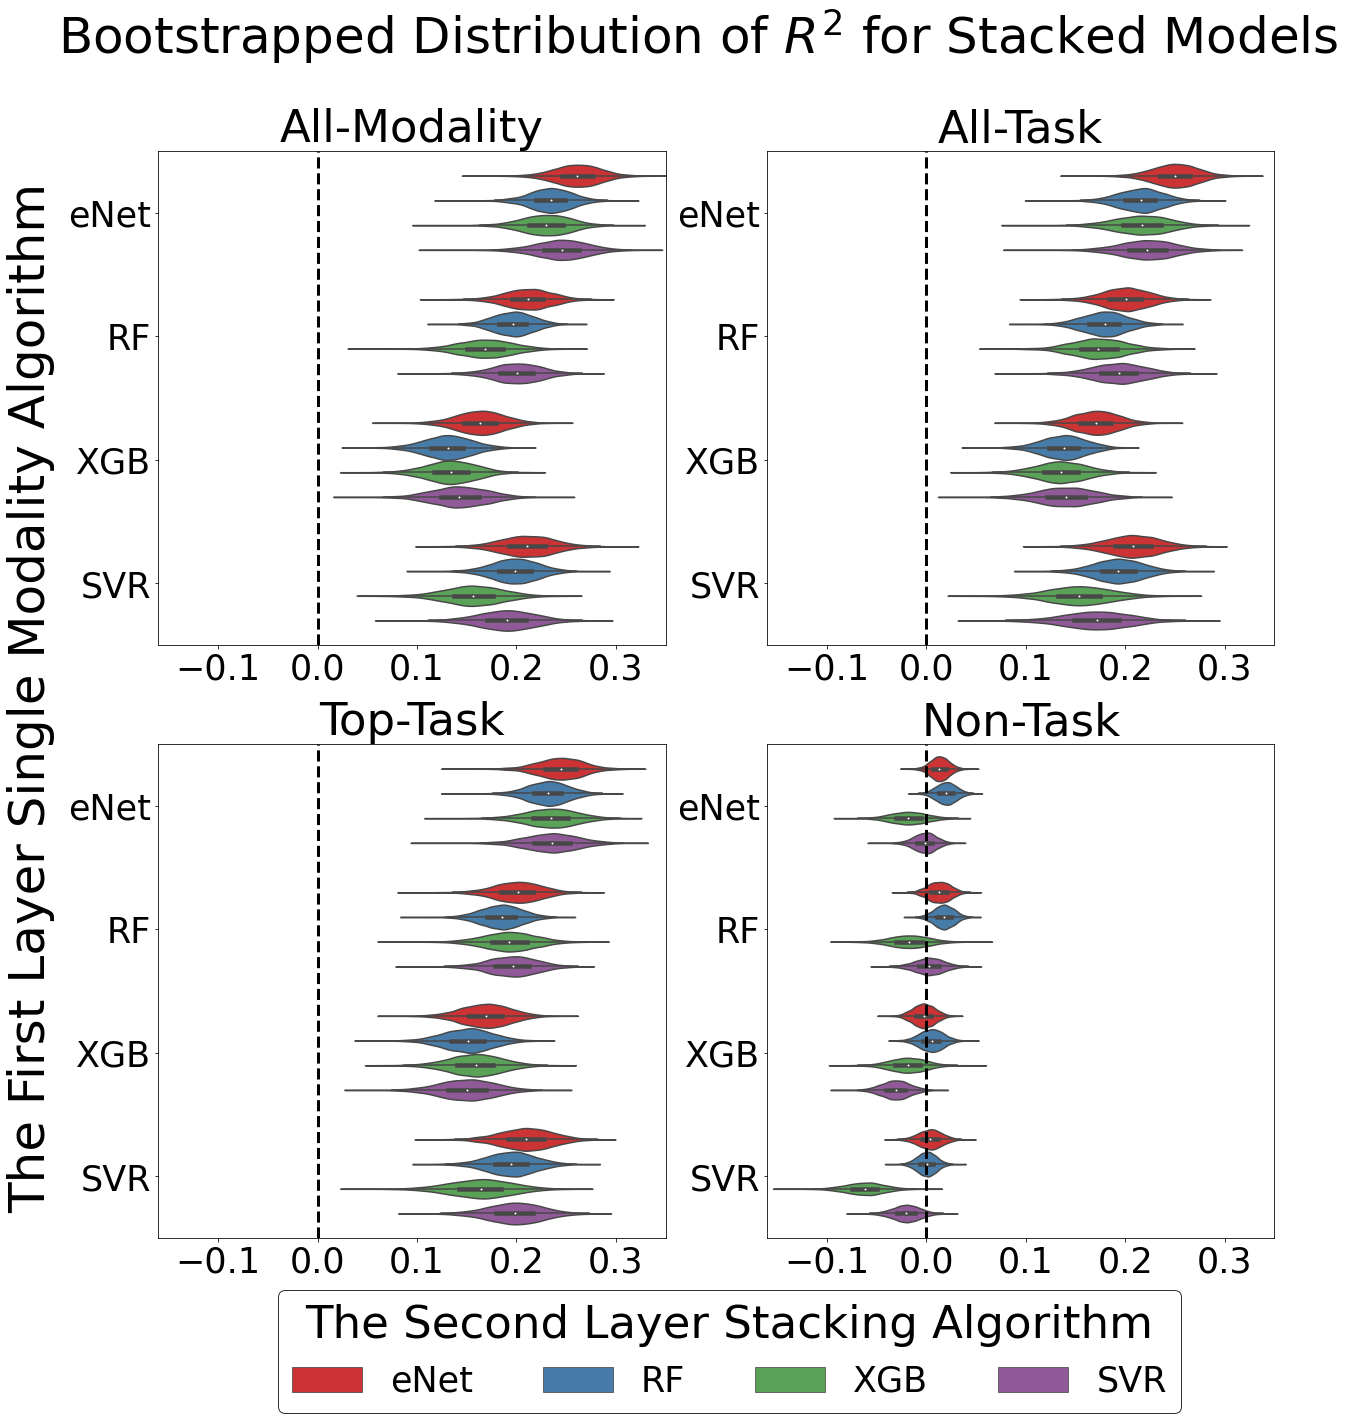

In [59]:
fig = plt.figure(figsize=(20,20))
palette = "Set1"
font1=28
font2=35
font3=45

plt.suptitle('Bootstrapped Distribution of $R^2$ for Stacked Models', fontsize=50)




plt.subplot(2,2,1)
plt.title('All-Modality', fontsize=font3)
sns.violinplot(x='$R^2$', y='Single Modality \nAlgorithm', hue='Stacking Algorithm', 
               data = dct_plot_tab_r2['all'][dct_plot_tab_r2['all']['Single Modality \nAlgorithm']!='flat'], 
               palette=palette,
               order=['eNet', 'RF', 'XGB','SVR'],
               hue_order=['eNet', 'RF', 'XGB','SVR'])
plt.legend([],[], frameon=False)
plt.xticks(fontsize=font2)
plt.yticks(fontsize=font2)
plt.xlabel('',fontsize=font3)
plt.ylabel('',fontsize=font3)
plt.xlim((-0.16, 0.35))
plt.axvline(0, color='black', linestyle='dashed', linewidth=3)




plt.subplot(2,2,2)
plt.title('All-Task', fontsize=font3)
sns.violinplot(x='$R^2$', y='Single Modality \nAlgorithm', hue='Stacking Algorithm', 
               data = dct_plot_tab_r2['task'][dct_plot_tab_r2['task']['Single Modality \nAlgorithm']!='flat'], 
               palette=palette,
               order=['eNet', 'RF', 'XGB','SVR'],
               hue_order=['eNet', 'RF', 'XGB','SVR'])
plt.legend([],[], frameon=False)
plt.xticks(fontsize=font2)
plt.yticks(fontsize=font2)
plt.xlabel('',fontsize=font3)
plt.ylabel('',fontsize=font3)
plt.xlim((-0.16, 0.35))
plt.axvline(0, color='black', linestyle='dashed', linewidth=3)



plt.subplot(2,2,4)
plt.title('Non-Task', fontsize=font3)
sns.violinplot(x='$R^2$', y='Single Modality \nAlgorithm', hue='Stacking Algorithm', 
               data = dct_plot_tab_r2['non-task'][dct_plot_tab_r2['non-task']['Single Modality \nAlgorithm']!='flat'], 
               palette=palette,
               order=['eNet', 'RF', 'XGB','SVR'],
               hue_order=['eNet', 'RF', 'XGB','SVR'])
plt.legend(loc='upper right', fontsize=font2, bbox_to_anchor=(0.85, -0.07), 
           title="The Second Layer Stacking Algorithm", title_fontsize=font3, ncol=4, edgecolor='black')

plt.xticks(fontsize=font2)
plt.yticks(fontsize=font2)
plt.xlabel('',fontsize=10)
plt.ylabel('',fontsize=font3)
plt.xlim((-0.16, 0.35))
plt.axvline(0, color='black', linestyle='dashed', linewidth=3)



plt.subplot(2,2,3)
plt.title('Top-Task', fontsize=font3)
sns.violinplot(x='$R^2$', y='Single Modality \nAlgorithm', hue='Stacking Algorithm', 
               data = dct_plot_tab_r2['top-task'][dct_plot_tab_r2['top-task']['Single Modality \nAlgorithm']!='flat'], 
               palette=palette,
               order=['eNet', 'RF', 'XGB','SVR'],
               hue_order=['eNet', 'RF', 'XGB','SVR'])
plt.legend([],[], frameon=False)
plt.xticks(fontsize=font2)
plt.yticks(fontsize=font2)
plt.xlabel('',fontsize=10)
plt.ylabel('',fontsize=font3)
plt.xlim((-0.16, 0.35))
plt.axvline(0, color='black', linestyle='dashed', linewidth=3)

#fig.tight_layout(pad=1)

#fig.supxlabel('$R^2$', fontsize=50)
fig.supylabel('The First Layer Single Modality Algorithm', fontsize=50)

plt.show()

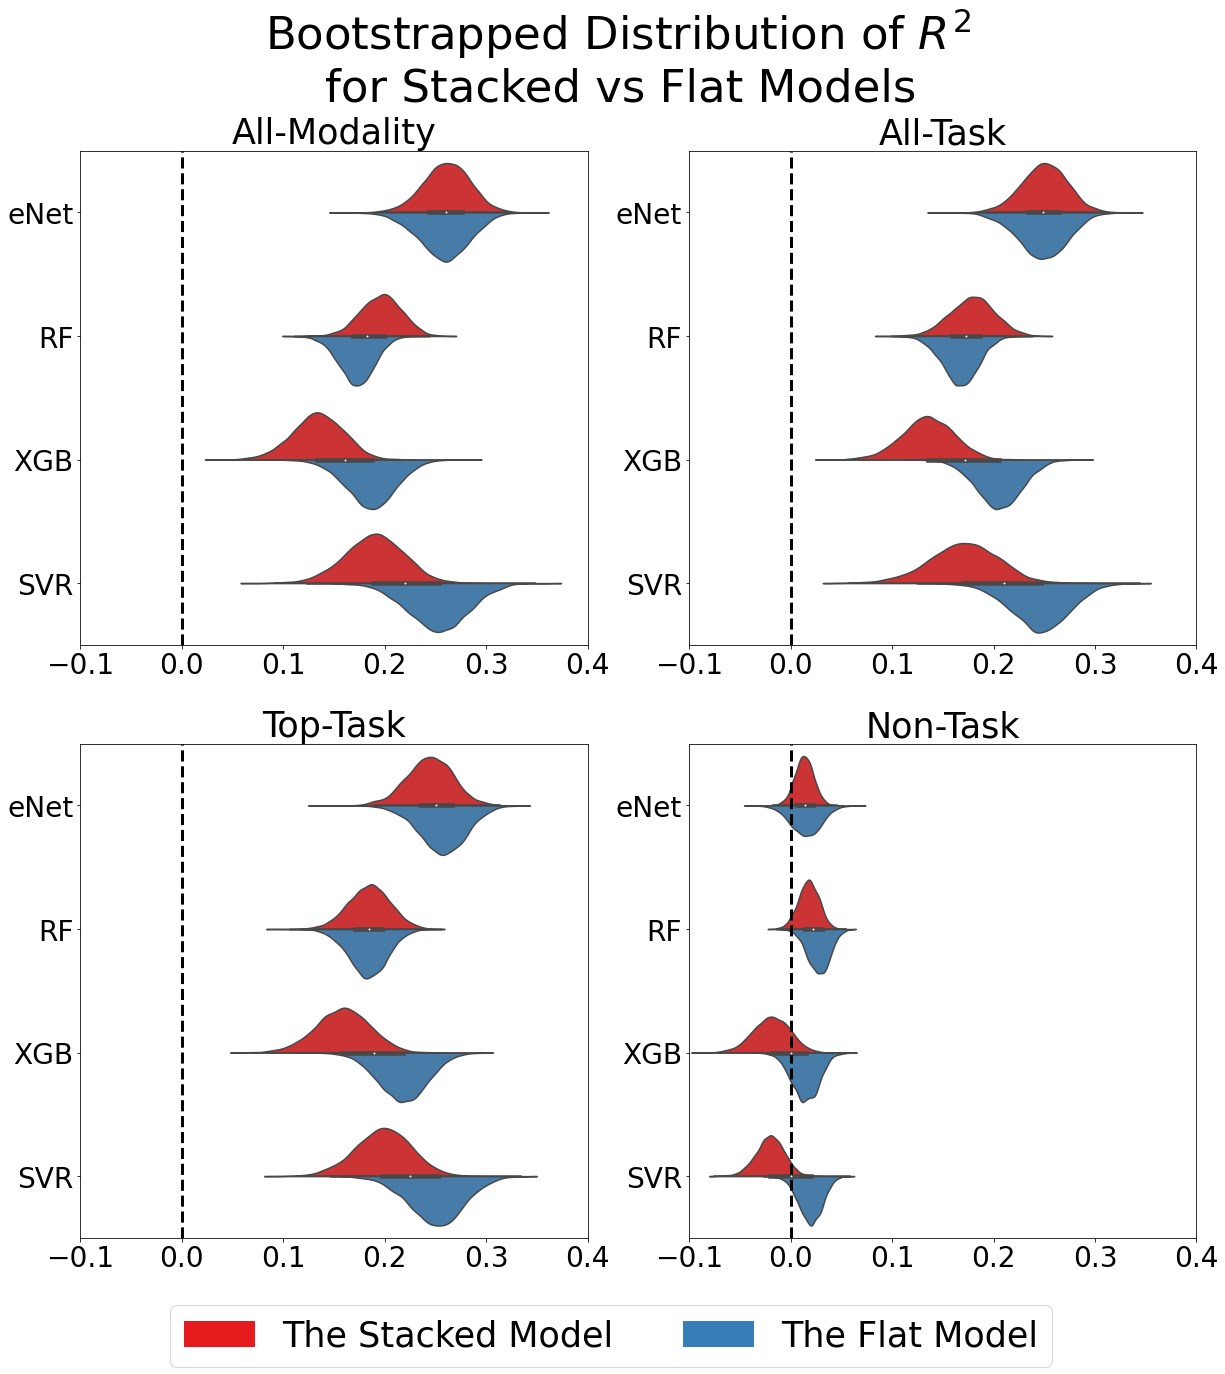

In [60]:
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

fig = plt.figure(figsize=(20,20))
palette = "Set1"
font1=28
font2=35
font3=45


plt.suptitle('Bootstrapped Distribution of $R^2$ \nfor Stacked vs Flat Models', fontsize=font3)


plt.subplot(2,2,1)
#####
st_type='all'
plt.title('All-Modality', fontsize=font2)
data1 = dct_plot_tab_r2[st_type][dct_plot_tab_r2[st_type]['Single Modality \nAlgorithm']=='flat']
data2 = dct_plot_tab_r2[st_type][dct_plot_tab_r2[st_type]['Single Modality \nAlgorithm']=='RF'][dct_plot_tab_r2[st_type]['Stacking Algorithm']=='RF']
data3 = dct_plot_tab_r2[st_type][dct_plot_tab_r2[st_type]['Single Modality \nAlgorithm']=='SVR'][dct_plot_tab_r2[st_type]['Stacking Algorithm']=='SVR']
data4 = dct_plot_tab_r2[st_type][dct_plot_tab_r2[st_type]['Single Modality \nAlgorithm']=='XGB'][dct_plot_tab_r2[st_type]['Stacking Algorithm']=='XGB']
data5 = dct_plot_tab_r2[st_type][dct_plot_tab_r2[st_type]['Single Modality \nAlgorithm']=='eNet'][dct_plot_tab_r2[st_type]['Stacking Algorithm']=='eNet']

Data = pd.concat([data2, data3, data4, data5, data1], axis=0, ignore_index=True)
Data = Data.sort_values(by=['Stacking Algorithm','Single Modality \nAlgorithm'])
for i in Data['Single Modality \nAlgorithm'].index:
    if Data.loc[i, 'Single Modality \nAlgorithm'] != 'flat':
        Data.loc[i, 'Single Modality \nAlgorithm'] = 'one'

sns.violinplot(x='$R^2$', y='Stacking Algorithm', hue='Single Modality \nAlgorithm', 
               data = Data, 
               palette=palette, split=True,
              order=['eNet', 'RF', 'XGB','SVR'])

plt.xticks(fontsize=font1)
plt.yticks(fontsize=font1)
plt.xlabel('',fontsize=font2)
plt.ylabel('',fontsize=font2)
plt.xlim((-0.1, 0.4))
plt.legend([],[], frameon=False)
plt.axvline(0, color='black', linestyle='dashed', linewidth=3)
#####



plt.subplot(2,2,2)
#####
st_type='task'
plt.title('All-Task', fontsize=font2)
data1 = dct_plot_tab_r2[st_type][dct_plot_tab_r2[st_type]['Single Modality \nAlgorithm']=='flat']
data2 = dct_plot_tab_r2[st_type][dct_plot_tab_r2[st_type]['Single Modality \nAlgorithm']=='RF'][dct_plot_tab_r2[st_type]['Stacking Algorithm']=='RF']
data3 = dct_plot_tab_r2[st_type][dct_plot_tab_r2[st_type]['Single Modality \nAlgorithm']=='SVR'][dct_plot_tab_r2[st_type]['Stacking Algorithm']=='SVR']
data4 = dct_plot_tab_r2[st_type][dct_plot_tab_r2[st_type]['Single Modality \nAlgorithm']=='XGB'][dct_plot_tab_r2[st_type]['Stacking Algorithm']=='XGB']
data5 = dct_plot_tab_r2[st_type][dct_plot_tab_r2[st_type]['Single Modality \nAlgorithm']=='eNet'][dct_plot_tab_r2[st_type]['Stacking Algorithm']=='eNet']

Data = pd.concat([data2, data3, data4, data5, data1], axis=0, ignore_index=True)
Data = Data.sort_values(by=['Stacking Algorithm','Single Modality \nAlgorithm'])
for i in Data['Single Modality \nAlgorithm'].index:
    if Data.loc[i, 'Single Modality \nAlgorithm'] != 'flat':
        Data.loc[i, 'Single Modality \nAlgorithm'] = 'one'

sns.violinplot(x='$R^2$', y='Stacking Algorithm', hue='Single Modality \nAlgorithm', 
               data = Data, 
               palette=palette, split=True,
              order=['eNet', 'RF', 'XGB','SVR'])

plt.xticks(fontsize=font1)
plt.yticks(fontsize=font1)
plt.xlabel('',fontsize=font2)
plt.ylabel('',fontsize=font2)
plt.xlim((-0.1, 0.4))
plt.legend([],[], frameon=False)
plt.axvline(0, color='black', linestyle='dashed', linewidth=3)
#####



plt.subplot(2,2,4)
#####
st_type='non-task'
plt.title('Non-Task', fontsize=font2)
data1 = dct_plot_tab_r2[st_type][dct_plot_tab_r2[st_type]['Single Modality \nAlgorithm']=='flat']
data2 = dct_plot_tab_r2[st_type][dct_plot_tab_r2[st_type]['Single Modality \nAlgorithm']=='RF'][dct_plot_tab_r2[st_type]['Stacking Algorithm']=='RF']
data3 = dct_plot_tab_r2[st_type][dct_plot_tab_r2[st_type]['Single Modality \nAlgorithm']=='SVR'][dct_plot_tab_r2[st_type]['Stacking Algorithm']=='SVR']
data4 = dct_plot_tab_r2[st_type][dct_plot_tab_r2[st_type]['Single Modality \nAlgorithm']=='XGB'][dct_plot_tab_r2[st_type]['Stacking Algorithm']=='XGB']
data5 = dct_plot_tab_r2[st_type][dct_plot_tab_r2[st_type]['Single Modality \nAlgorithm']=='eNet'][dct_plot_tab_r2[st_type]['Stacking Algorithm']=='eNet']

Data = pd.concat([data2, data3, data4, data5, data1], axis=0, ignore_index=True)
Data = Data.sort_values(by=['Stacking Algorithm','Single Modality \nAlgorithm'])
for i in Data['Single Modality \nAlgorithm'].index:
    if Data.loc[i, 'Single Modality \nAlgorithm'] != 'flat':
        Data.loc[i, 'Single Modality \nAlgorithm'] = 'one'

sns.violinplot(x='$R^2$', y='Stacking Algorithm', hue='Single Modality \nAlgorithm', 
               data = Data, 
               palette=palette, split=True,
              order=['eNet', 'RF', 'XGB','SVR'])

plt.xticks(fontsize=font1)
plt.yticks(fontsize=font1)
plt.xlabel('',fontsize=font2)
plt.ylabel('',fontsize=font2)
plt.xlim((-0.1, 0.4))
plt.legend(handles=[mpatches.Patch(color=sns.color_palette("Set1")[0], label='The Stacked Model'), 
                    mpatches.Patch(color=sns.color_palette("Set1")[1], label='The Flat Model')],
          bbox_to_anchor=(0.75, -0.1), fontsize=font2, ncol=2)
plt.axvline(0, color='black', linestyle='dashed', linewidth=3)
#####



plt.subplot(2,2,3)
#####
st_type='top-task'
plt.title('Top-Task', fontsize=font2)
data1 = dct_plot_tab_r2[st_type][dct_plot_tab_r2[st_type]['Single Modality \nAlgorithm']=='flat']
data2 = dct_plot_tab_r2[st_type][dct_plot_tab_r2[st_type]['Single Modality \nAlgorithm']=='RF'][dct_plot_tab_r2[st_type]['Stacking Algorithm']=='RF']
data3 = dct_plot_tab_r2[st_type][dct_plot_tab_r2[st_type]['Single Modality \nAlgorithm']=='SVR'][dct_plot_tab_r2[st_type]['Stacking Algorithm']=='SVR']
data4 = dct_plot_tab_r2[st_type][dct_plot_tab_r2[st_type]['Single Modality \nAlgorithm']=='XGB'][dct_plot_tab_r2[st_type]['Stacking Algorithm']=='XGB']
data5 = dct_plot_tab_r2[st_type][dct_plot_tab_r2[st_type]['Single Modality \nAlgorithm']=='eNet'][dct_plot_tab_r2[st_type]['Stacking Algorithm']=='eNet']

Data = pd.concat([data2, data3, data4, data5, data1], axis=0, ignore_index=True)
Data = Data.sort_values(by=['Stacking Algorithm','Single Modality \nAlgorithm'])
for i in Data['Single Modality \nAlgorithm'].index:
    if Data.loc[i, 'Single Modality \nAlgorithm'] != 'flat':
        Data.loc[i, 'Single Modality \nAlgorithm'] = 'one'

sns.violinplot(x='$R^2$', y='Stacking Algorithm', hue='Single Modality \nAlgorithm', 
               data = Data, 
               palette=palette, split=True,
              order=['eNet', 'RF', 'XGB','SVR'])

plt.xticks(fontsize=font1)
plt.yticks(fontsize=font1)
plt.xlabel('',fontsize=font2)
plt.ylabel('',fontsize=font2)
plt.xlim((-0.1, 0.4))
plt.legend([],[], frameon=False)
plt.axvline(0, color='black', linestyle='dashed', linewidth=3)
#####



plt.show()

# CV

### calculate cross-validation scores

In [22]:
dct_cv_r2 = {}
dct_cv_mse = {}
dct_cv_mae = {}
dct_cv_cor = {}
dct_cv_MEAN  = {}
dct_cv_STD  = {}

for KEY in dct_results.keys():
    #KEY= 'eNet'    #+eNet
    data = dct_results[KEY]



    dt_cv={}
    for i in range(8):
        dt=data[data['fold']==str(i)]


        cor, r2, mse, mae, cols = [], [], [], [], []
        for col in dt.columns[:-2]:
            cols += [col]
            r2 += [r2_score(dt['y_real'], dt[col])]
            mse += [mean_squared_error(dt['y_real'], dt[col])]
            mae += [mean_absolute_error(dt['y_real'], dt[col])]
            cor += [pearsonr(dt['y_real'], dt[col])[0]]
        dt_cv['fold_'+str(i)] = pd.DataFrame({'r2':r2, 'mse':mse, 'mae':mae, 'cor':cor}, index = cols)

    dcv_r2 = {}
    dcv_mse = {}
    dcv_mae = {}
    dcv_cor = {}
    #assign each index to own dict
    for key in dt_cv.keys():
        dcv_r2[key] = dt_cv[key].iloc[:,0]
        dcv_mse[key] = dt_cv[key].iloc[:,1]
        dcv_mae[key] = dt_cv[key].iloc[:,2]
        dcv_cor[key] = dt_cv[key].iloc[:,3]

    dcv_r2 = pd.DataFrame(dcv_r2).T
    dcv_mse = pd.DataFrame(dcv_mse).T
    dcv_mae = pd.DataFrame(dcv_mae).T
    dcv_cor = pd.DataFrame(dcv_cor).T

    #store in dictionaries
    dct_cv_r2[KEY] = dcv_r2
    dct_cv_mse[KEY] = dcv_mse
    dct_cv_mae[KEY] = dcv_mae
    dct_cv_cor[KEY] = dcv_cor
    
    #create table with mean performance
    cv_mean = pd.DataFrame({'r2': np.array(dcv_r2.mean()),
                            'mse': np.array(dcv_mse.mean()),
                            'mae': np.array(dcv_mae.mean()),
                            'cor': np.array(dcv_cor.mean())
                                 }, index = dcv_r2.columns)
    cv_std = pd.DataFrame({'r2': np.array(dcv_r2.std()),
                            'mse': np.array(dcv_mse.std()),
                            'mae': np.array(dcv_mae.std()),
                            'cor': np.array(dcv_cor.std())
                                 }, index = dcv_r2.columns)
    
    dct_cv_MEAN[KEY] = cv_mean
    dct_cv_STD[KEY] = cv_std

    #display
    print(KEY)
    print('Mean Performance based on Cross-Validation across Eight Test Folds')
    display(cv_mean.sort_values(by='r2', ascending=False))

eNet+eNet
Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
all,0.258900,121.728767,8.940876,0.522284
task,0.248031,123.556576,8.965784,0.514940
top-task,0.243143,124.560294,9.003464,0.511954
non-task,0.014242,162.642527,10.306241,0.138057


eNet+rf
Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
all,0.232009,126.138384,9.099528,0.495013
top-task,0.230173,126.690037,9.069187,0.492282
task,0.210875,129.322404,9.131269,0.485388
non-task,0.020305,161.490782,10.268676,0.129641


eNet+svr
Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
all,0.242867,124.364772,8.994486,0.513652
top-task,0.235503,126.004532,9.080386,0.500637
task,0.221015,128.159409,9.147044,0.485206
non-task,0.000037,165.128742,10.305762,0.110183


eNet+xgb
Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
top-task,0.233395,126.194534,8.970545,0.491461
all,0.226683,126.880172,9.093838,0.481159
task,0.215119,129.067728,9.012643,0.474124
non-task,-0.021264,167.714299,10.530760,0.100073


eNet
Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
wm,0.192285,133.031363,9.207479,0.440006
lan,0.101791,147.173930,9.768957,0.341773
rel,0.062593,155.257402,9.983406,0.272223
soc,0.037042,159.156486,10.144912,0.198870
surf,0.025482,160.686746,10.260276,0.167371
mot,0.023096,160.899546,10.239216,0.154231
emo,0.019986,161.394474,10.230723,0.176951
VolBrain,0.008581,163.512975,10.346942,0.105779
cort,0.003062,164.607059,10.306209,0.079219
subc,-0.000881,164.768014,10.398139,0.076214


rf+eNet
Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
all,0.211446,129.967743,9.203443,0.467600
top-task,0.201196,131.732851,9.233142,0.465803
task,0.200761,131.834065,9.250752,0.460015
non-task,0.011720,162.742906,10.304631,0.138824


rf+rf
Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
all,0.194739,132.411871,9.277351,0.456268
top-task,0.183403,134.385218,9.308298,0.453545
task,0.175630,135.266432,9.344132,0.432309
non-task,0.017875,161.926274,10.271780,0.140844


rf+svr
Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
all,0.199422,131.795703,9.241639,0.467880
top-task,0.195717,132.609932,9.240841,0.464111
task,0.192994,133.004962,9.223240,0.461366
non-task,0.001260,164.339638,10.305914,0.141009


rf+xgb
Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
top-task,0.192471,133.016332,9.246647,0.449322
task,0.171488,136.161413,9.364422,0.426654
all,0.162628,136.895830,9.471296,0.423626
non-task,-0.019017,167.665645,10.432030,0.127724


rf
Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
wm,0.142591,141.317279,9.536173,0.380976
lan,0.093958,149.343887,9.838205,0.329309
rel,0.054216,156.610697,10.080485,0.243505
soc,0.031056,159.778207,10.148900,0.171867
emo,0.027576,160.301580,10.187934,0.175817
surf,0.019454,161.729848,10.265827,0.150724
mot,0.012394,162.818522,10.326423,0.097273
VolBrain,0.012056,162.909231,10.340846,0.112373
subc,0.009472,163.011753,10.332405,0.126873
gam,0.000051,165.016561,10.356654,0.056664


svr+eNet
Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
all,0.209776,130.018737,9.206899,0.465187
top-task,0.208261,130.256666,9.132024,0.475692
task,0.207235,130.528989,9.179171,0.464083
non-task,0.004021,164.228369,10.336400,0.113742


svr+rf
Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
all,0.197454,132.048331,9.251044,0.446775
top-task,0.192863,132.753669,9.197083,0.449384
task,0.192089,132.963002,9.240410,0.442542
non-task,0.000831,164.765411,10.375676,0.080471


svr+svr
Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
top-task,0.197388,132.087732,9.130808,0.469485
all,0.189705,133.497074,9.223342,0.464137
task,0.172478,136.620497,9.308521,0.456723
non-task,-0.019774,168.199393,10.428605,0.050922


svr+xgb
Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
top-task,0.158742,137.745925,9.272688,0.423963
all,0.154429,138.909406,9.439867,0.414100
task,0.153369,139.377742,9.382131,0.421841
non-task,-0.063762,175.007778,10.634709,0.030643


svr
Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
wm,0.151256,139.417483,9.375321,0.406491
lan,0.081998,150.721560,9.793149,0.321799
rel,0.055507,156.480563,10.007354,0.272695
surf,0.019967,161.705148,10.199223,0.159712
mot,0.019160,161.714422,10.253967,0.166789
soc,0.018677,161.690305,10.201348,0.179318
emo,-0.008000,165.896645,10.277924,0.141189
cort,-0.012295,166.949094,10.335511,0.051526
rest-pca75,-0.012889,167.171879,10.406057,0.045045
VolBrain,-0.016757,167.503481,10.436723,0.075252


xgb+eNet
Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
task,0.169229,136.754586,9.422942,0.428666
top-task,0.167333,137.048821,9.391367,0.428532
all,0.162119,137.901869,9.486846,0.418357
non-task,-0.004586,165.267880,10.405887,0.131782


xgb+rf
Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
top-task,0.151024,140.008124,9.410471,0.406697
task,0.138208,142.086382,9.487475,0.391715
all,0.130603,143.274139,9.533814,0.391844
non-task,0.002770,163.990909,10.382288,0.121141


xgb+svr
Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
top-task,0.148348,140.128130,9.403982,0.425312
all,0.140023,141.252849,9.545083,0.416669
task,0.135981,141.647425,9.539799,0.419633
non-task,-0.035069,169.922754,10.516300,0.089096


xgb+xgb
Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
top-task,0.158831,138.676196,9.376163,0.414349
task,0.135347,142.527107,9.523948,0.388175
all,0.133171,142.688857,9.555544,0.384206
non-task,-0.021793,167.918700,10.480960,0.109761


xgb
Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
wm,0.099984,148.023477,9.683473,0.335120
lan,0.075954,151.955095,9.817961,0.296627
rel,0.038410,159.308089,10.165544,0.228574
soc,0.028118,160.191852,10.158130,0.173545
subc,0.011995,162.360165,10.318210,0.133189
emo,0.010226,163.116400,10.287042,0.137611
VolBrain,0.000050,164.911935,10.419997,0.091677
surf,-0.004747,165.499351,10.396973,0.115452
gam,-0.005952,166.102458,10.364663,0.065669
rest-pca75,-0.013768,167.426832,10.433239,0.017173


flat+eNet
Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
top-task,0.257492,122.469644,8.966640,0.510985
all,0.257405,122.202243,8.999153,0.513172
task,0.249325,123.901898,9.034067,0.505344
non-task,0.013480,162.356783,10.298537,0.158395


flat+rf
Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
top-task,0.183780,134.642285,9.368427,0.445410
all,0.173196,136.489192,9.430874,0.439568
task,0.168367,137.309713,9.444793,0.430774
non-task,0.027656,160.300605,10.241748,0.168319


flat+svr
Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
top-task,0.250413,123.505133,8.901707,0.510157
all,0.249607,123.142000,8.968910,0.511066
task,0.245722,124.283853,8.968524,0.506501
non-task,0.018322,161.636829,10.295552,0.147566


flat+xgb
Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
top-task,0.216127,128.902562,9.119674,0.470881
task,0.205429,131.008950,9.191181,0.459246
all,0.186674,134.126177,9.313219,0.438903
non-task,0.015357,162.500448,10.305751,0.142826


In [23]:
for key in dct_cv_STD.keys():
    
    print(key)
    print('Standard Deviation of Mean Performance based on Cross-Validation across Eight Test Folds')
    display(dct_cv_STD[key].reindex(index=dct_cv_MEAN[key].sort_values(by='r2', ascending=False).index))

eNet+eNet
Standard Deviation of Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
all,0.085238,17.421662,0.845066,0.089163
task,0.078810,16.804345,0.835211,0.091679
top-task,0.068467,17.545701,0.880936,0.081766
non-task,0.034041,22.361739,0.941696,0.119328


eNet+rf
Standard Deviation of Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
all,0.073481,16.464812,0.851978,0.079746
top-task,0.052241,16.635225,0.896030,0.063824
task,0.095399,15.814415,0.826048,0.082431
non-task,0.046107,21.697710,0.848231,0.170824


eNet+svr
Standard Deviation of Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
all,0.110476,20.956036,0.955862,0.091339
top-task,0.072187,19.894052,0.962462,0.067400
task,0.079963,19.009470,0.874986,0.076795
non-task,0.028653,23.749648,0.938947,0.135525


eNet+xgb
Standard Deviation of Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
top-task,0.066127,17.853464,0.925246,0.057752
all,0.082546,16.713901,0.820473,0.075251
task,0.075240,17.680822,0.829264,0.061519
non-task,0.101581,21.755423,0.772879,0.185505


eNet
Standard Deviation of Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
wm,0.070808,18.786833,0.876085,0.082960
lan,0.111028,18.516665,0.863522,0.132334
rel,0.066469,27.314385,1.077045,0.110307
soc,0.027814,23.300647,1.063632,0.084390
surf,0.030749,21.269756,0.915681,0.097870
mot,0.025409,19.012258,0.815131,0.073897
emo,0.047512,20.452851,0.835548,0.079744
VolBrain,0.023981,21.643901,0.905765,0.107079
cort,0.013521,22.857925,0.943204,0.060871
subc,0.027658,19.135882,0.857902,0.131774


rf+eNet
Standard Deviation of Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
all,0.060973,18.785049,0.859127,0.070612
top-task,0.068189,19.903443,0.929945,0.075054
task,0.058677,19.118262,0.923588,0.072077
non-task,0.044911,20.335400,0.814156,0.122905


rf+rf
Standard Deviation of Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
all,0.049894,15.660587,0.747984,0.070049
top-task,0.052546,16.850312,0.836320,0.075026
task,0.058375,13.321347,0.721787,0.075104
non-task,0.035170,21.567320,0.864525,0.130378


rf+svr
Standard Deviation of Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
all,0.064126,18.014099,0.817527,0.069140
top-task,0.067952,19.751625,0.902981,0.070752
task,0.065731,19.061136,0.881197,0.074139
non-task,0.042023,19.075968,0.751238,0.127392


rf+xgb
Standard Deviation of Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
top-task,0.069685,19.027174,0.883870,0.064706
task,0.074392,17.178669,0.845443,0.077934
all,0.096144,13.164221,0.650653,0.083818
non-task,0.064258,21.003942,0.863861,0.102125


rf
Standard Deviation of Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
wm,0.064319,19.883358,0.941353,0.086682
lan,0.060919,20.937596,0.927882,0.108607
rel,0.061173,26.690837,1.108710,0.123299
soc,0.031240,20.641093,0.894220,0.090658
emo,0.026499,20.640754,0.857464,0.068730
surf,0.030921,21.851962,0.910477,0.087535
mot,0.025993,20.718271,0.898246,0.110914
VolBrain,0.034828,21.968821,0.898103,0.129891
subc,0.037005,18.927826,0.817951,0.156664
gam,0.010826,22.119395,0.895822,0.064155


svr+eNet
Standard Deviation of Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
all,0.084424,19.377172,0.915652,0.084698
top-task,0.091712,19.917095,0.914474,0.096921
task,0.078392,19.168433,0.922764,0.082070
non-task,0.053337,22.735300,0.953693,0.169452


svr+rf
Standard Deviation of Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
all,0.077014,19.012982,0.868280,0.088302
top-task,0.074022,18.079503,0.857943,0.085905
task,0.065737,17.980148,0.870120,0.072475
non-task,0.028205,21.689700,0.843092,0.117743


svr+svr
Standard Deviation of Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
top-task,0.082321,19.622791,0.903098,0.090996
all,0.095951,22.325945,0.929956,0.089981
task,0.103747,25.775353,0.923513,0.075288
non-task,0.039333,22.795497,0.899851,0.161432


svr+xgb
Standard Deviation of Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
top-task,0.118108,18.397126,0.765013,0.098295
all,0.096689,19.737151,0.846495,0.084631
task,0.093715,21.304113,0.939236,0.075169
non-task,0.073260,21.823541,0.816048,0.114808


svr
Standard Deviation of Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
wm,0.081830,17.186511,0.792306,0.081387
lan,0.125844,23.075061,0.942991,0.139012
rel,0.078877,28.497878,1.140040,0.123504
surf,0.035419,22.358492,0.927877,0.098157
mot,0.049750,21.566962,0.975792,0.102971
soc,0.048041,20.576257,0.920419,0.095844
emo,0.037136,19.466985,0.886976,0.068105
cort,0.017648,21.724847,0.890988,0.059548
rest-pca75,0.015076,22.807126,0.909953,0.088133
VolBrain,0.047417,21.544120,0.853884,0.105355


xgb+eNet
Standard Deviation of Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
task,0.063409,17.789261,0.892005,0.084244
top-task,0.066099,18.070187,0.882220,0.077650
all,0.071093,18.990090,0.866831,0.090074
non-task,0.053284,19.575712,0.817363,0.140592


xgb+rf
Standard Deviation of Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
top-task,0.083101,22.778333,0.828216,0.096995
task,0.071415,21.477692,0.821503,0.094929
all,0.094353,23.369078,0.843501,0.120091
non-task,0.049016,18.538521,0.743233,0.129116


xgb+svr
Standard Deviation of Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
top-task,0.085455,20.013194,0.866864,0.088200
all,0.092981,19.661503,0.874094,0.093424
task,0.094635,16.858030,0.735565,0.097316
non-task,0.074044,17.962527,0.719548,0.139305


xgb+xgb
Standard Deviation of Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
top-task,0.070018,20.579363,0.831014,0.073739
task,0.083640,22.325760,0.834982,0.092216
all,0.082495,20.842818,0.772905,0.092607
non-task,0.060306,18.682013,0.714007,0.094463


xgb
Standard Deviation of Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
wm,0.079342,19.273409,0.874676,0.087039
lan,0.089938,21.432715,0.845107,0.116938
rel,0.060984,28.051068,1.104607,0.114260
soc,0.034808,20.252386,0.851781,0.104980
subc,0.056252,17.678438,0.735016,0.149076
emo,0.033258,20.892524,0.854072,0.058421
VolBrain,0.034418,22.253782,0.904235,0.114701
surf,0.051230,21.242457,0.901723,0.101658
gam,0.024655,23.152170,0.946942,0.077735
rest-pca75,0.021318,24.067292,0.938207,0.079439


flat+eNet
Standard Deviation of Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
top-task,0.068264,19.173620,0.897390,0.072358
all,0.074287,17.721317,0.878343,0.075478
task,0.063587,19.444703,0.931443,0.068869
non-task,0.051817,19.768071,0.886579,0.099058


flat+rf
Standard Deviation of Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
top-task,0.062939,19.928164,0.972474,0.093744
all,0.058661,20.717294,0.980845,0.098032
task,0.056898,20.733676,1.008728,0.092985
non-task,0.035030,21.129038,0.899829,0.108290


flat+svr
Standard Deviation of Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
top-task,0.091374,20.957836,0.922951,0.082450
all,0.107930,19.193839,0.886847,0.088316
task,0.077483,19.154363,0.900604,0.064655
non-task,0.048200,20.423561,0.876559,0.145868


flat+xgb
Standard Deviation of Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
top-task,0.071543,17.222709,0.880399,0.080639
task,0.074874,20.152745,1.000360,0.085008
all,0.079084,20.736359,1.038831,0.091092
non-task,0.029717,22.726535,0.956258,0.088212


In [24]:
#save tables
os.mkdir(path_out+'cv_table')
for key in dct_cv_r2.keys():
    dct_cv_r2[key].to_csv(path_out+'cv_table/'+'CV_r2_'+str(key)+'.csv')
    dct_cv_mse[key].to_csv(path_out+'cv_table/'+'CV_mse_'+str(key)+'.csv')
    dct_cv_mae[key].to_csv(path_out+'cv_table/'+'CV_mae_'+str(key)+'.csv')
    dct_cv_cor[key].to_csv(path_out+'cv_table/'+'CV_cor_'+str(key)+'.csv')
    dct_cv_MEAN[key].to_csv(path_out+'cv_table/'+'CV_MEAN_'+str(key)+'.csv')


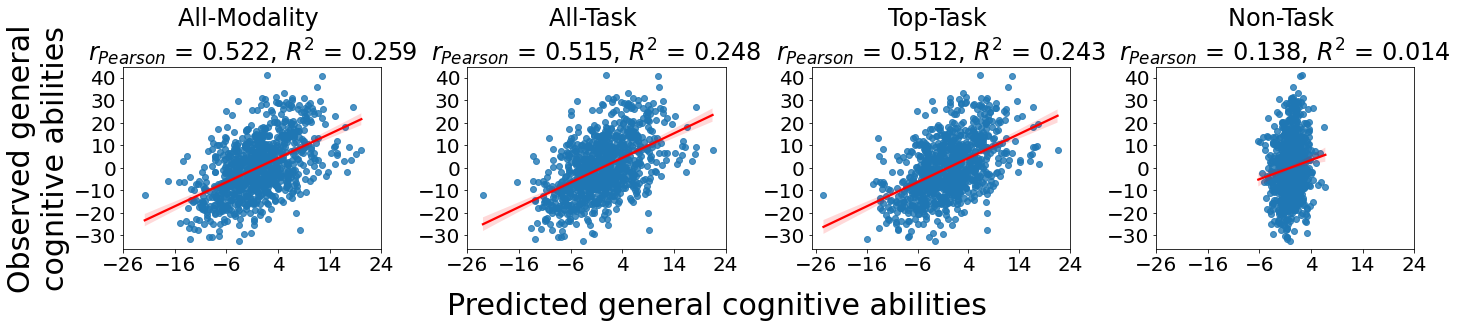

In [25]:
fig = plt.figure(figsize=(20,5))
#plt.suptitle('Relationship between observed and predicted general cognitive abilities \nbased on stacked models with eNet+eNet across eight held-out folds',fontsize=32)

df_y_all = dct_results['eNet+eNet']


plt.subplot(1,4,1)
col='all'
crr, _ = pearsonr(df_y_all['y_real'], df_y_all[col])
sns.regplot(x=col, y='y_real', data=df_y_all, fit_reg=True, line_kws={'color': 'red'}) 
plt.xticks(np.arange(-26, 26, 10), fontsize=20)
plt.yticks(fontsize=20)
#plt.xlabel('Predicted\ngeneral cognitive abilities', fontsize=21)
plt.xlabel(' ')
plt.ylabel('Observed general\ncognitive abilities', fontsize=30)
plt.title('All-Modality '+'\n'+'$r_{Pearson}$ = '+str(dct_cv_MEAN['eNet+eNet'].loc[col,'cor'].round(3))+
          ', $R^2$ = '+str(dct_cv_MEAN['eNet+eNet'].loc[col,'r2'].round(3)), fontsize=24)

plt.subplot(1,4,2)
col = 'task'  
crr, _ = pearsonr(df_y_all['y_real'], df_y_all[col])
sns.regplot(x=col, y='y_real', data=df_y_all, fit_reg=True, line_kws={'color': 'red'}) 
plt.xticks(np.arange(-26, 26, 10), fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(' ', fontsize=30)
#plt.ylabel('Observed\ngeneral cognitive abilities', fontsize=21)
plt.ylabel(' ')
plt.title('All-Task '+'\n'+'$r_{Pearson}$ = '+str(dct_cv_MEAN['eNet+eNet'].loc[col,'cor'].round(3))+
          ', $R^2$ = '+str(dct_cv_MEAN['eNet+eNet'].loc[col,'r2'].round(3)), fontsize=24)

plt.subplot(1,4,4)
col = 'non-task'
crr, _ = pearsonr(df_y_all['y_real'], df_y_all[col])
sns.regplot(x=col, y='y_real', data=df_y_all, fit_reg=True, line_kws={'color': 'red'}) 
plt.xticks(np.arange(-26, 26, 10), fontsize=20)
plt.yticks(fontsize=20)
#plt.xlabel('Predicted\ngeneral cognitive abilities', fontsize=21)
#plt.ylabel('Observed\ngeneral cognitive abilities', fontsize=21)  
plt.xlabel(' ')
plt.ylabel(' ')
plt.title('Non-Task '+'\n'+'$r_{Pearson}$ = '+str(dct_cv_MEAN['eNet+eNet'].loc[col,'cor'].round(3))+
          ', $R^2$ = '+str(dct_cv_MEAN['eNet+eNet'].loc[col,'r2'].round(3)), fontsize=24)

plt.subplot(1,4,3)
col = 'top-task'
crr, _ = pearsonr(df_y_all['y_real'], df_y_all[col])
sns.regplot(x=col, y='y_real', data=df_y_all, fit_reg=True, line_kws={'color': 'red'}) 
plt.xticks(np.arange(-26, 26, 10), fontsize=20)
plt.yticks(fontsize=20)
#plt.xlabel('Predicted\ngeneral cognitive abilities', fontsize=21)
#plt.ylabel('Observed\ngeneral cognitive abilities', fontsize=21)  
plt.xlabel(' ')
plt.ylabel(' ')
plt.title('Top-Task '+'\n'+'$r_{Pearson}$ = '+str(dct_cv_MEAN['eNet+eNet'].loc[col,'cor'].round(3))+
          ', $R^2$ = '+str(dct_cv_MEAN['eNet+eNet'].loc[col,'r2'].round(3)), fontsize=24)

#plt.supxlabel()
fig.supxlabel('Predicted general cognitive abilities', fontsize=30, y=0.1)
fig.tight_layout(pad=1.0)
plt.show()

##### reorganize tables for plotting

###### r2

In [26]:
#stack into one table for plot


dct_cv_plot_stacked_r2 = {}

for model in dct_cv_r2['eNet+eNet'].columns:


    #combine into one table by type of model
    v1 = []
    v2 = []
    dfdf = pd.DataFrame()
    for key in dct_cv_r2.keys():
        if model in dct_cv_r2['eNet+eNet'].columns[1:] and 'flat' not in key:
            if len(key.split('+')) >=2:
                v1 += [key.split('+')[0]]
                v2 += [key.split('+')[1]]
                dfdf[key] = dct_cv_r2[key][model]
        if dct_cv_r2['eNet+eNet'].columns[0] in model:
            if len(key.split('+')) >=2:
                v1 += [key.split('+')[0]]
                v2 += [key.split('+')[1]]
                dfdf[key] = dct_cv_r2[key][model]            

    V1=[]
    for i in v1:
        if i in ['svr', 'rf', 'xgb']:
            V1 += [i.upper()]
        else: 
            V1 += [i]    
    V2=[]
    for i in v2:
        if i in ['svr', 'rf', 'xgb']:
            V2 += [i.upper()]
        else: 
            V2 += [i]    

    #multi-index        
    collumnss = pd.MultiIndex.from_tuples(list(zip( V1,V2)), names=["single", "stack"])
    dfdf.columns=collumnss


    #reorganize table into long one for easy plotting

    dct_t2 = {}
    for col in dfdf.columns:
        nums = dfdf[col].values
        inds1 = np.full(len(dfdf[col].values), col[0])
        inds2 = np.full(len(dfdf[col].values), col[1])
        dct_t2[('_'.join(col))] = pd.DataFrame({'$R^2$': nums, 'Single Modality \nAlgorithm':inds1, 
                                                'Stacking Algorithm':inds2})

    #table for plot
    dfdf2 = dct_t2[sorted(dct_t2.keys())[0]]
    for key in sorted(dct_t2.keys())[1:]:
        dfdf2 = pd.concat([dfdf2, dct_t2[key]], axis=0, ignore_index=True)
    #display(dfdf2)

    dct_cv_plot_stacked_r2[model]=dfdf2

## CV plotting

###### CV stacked models

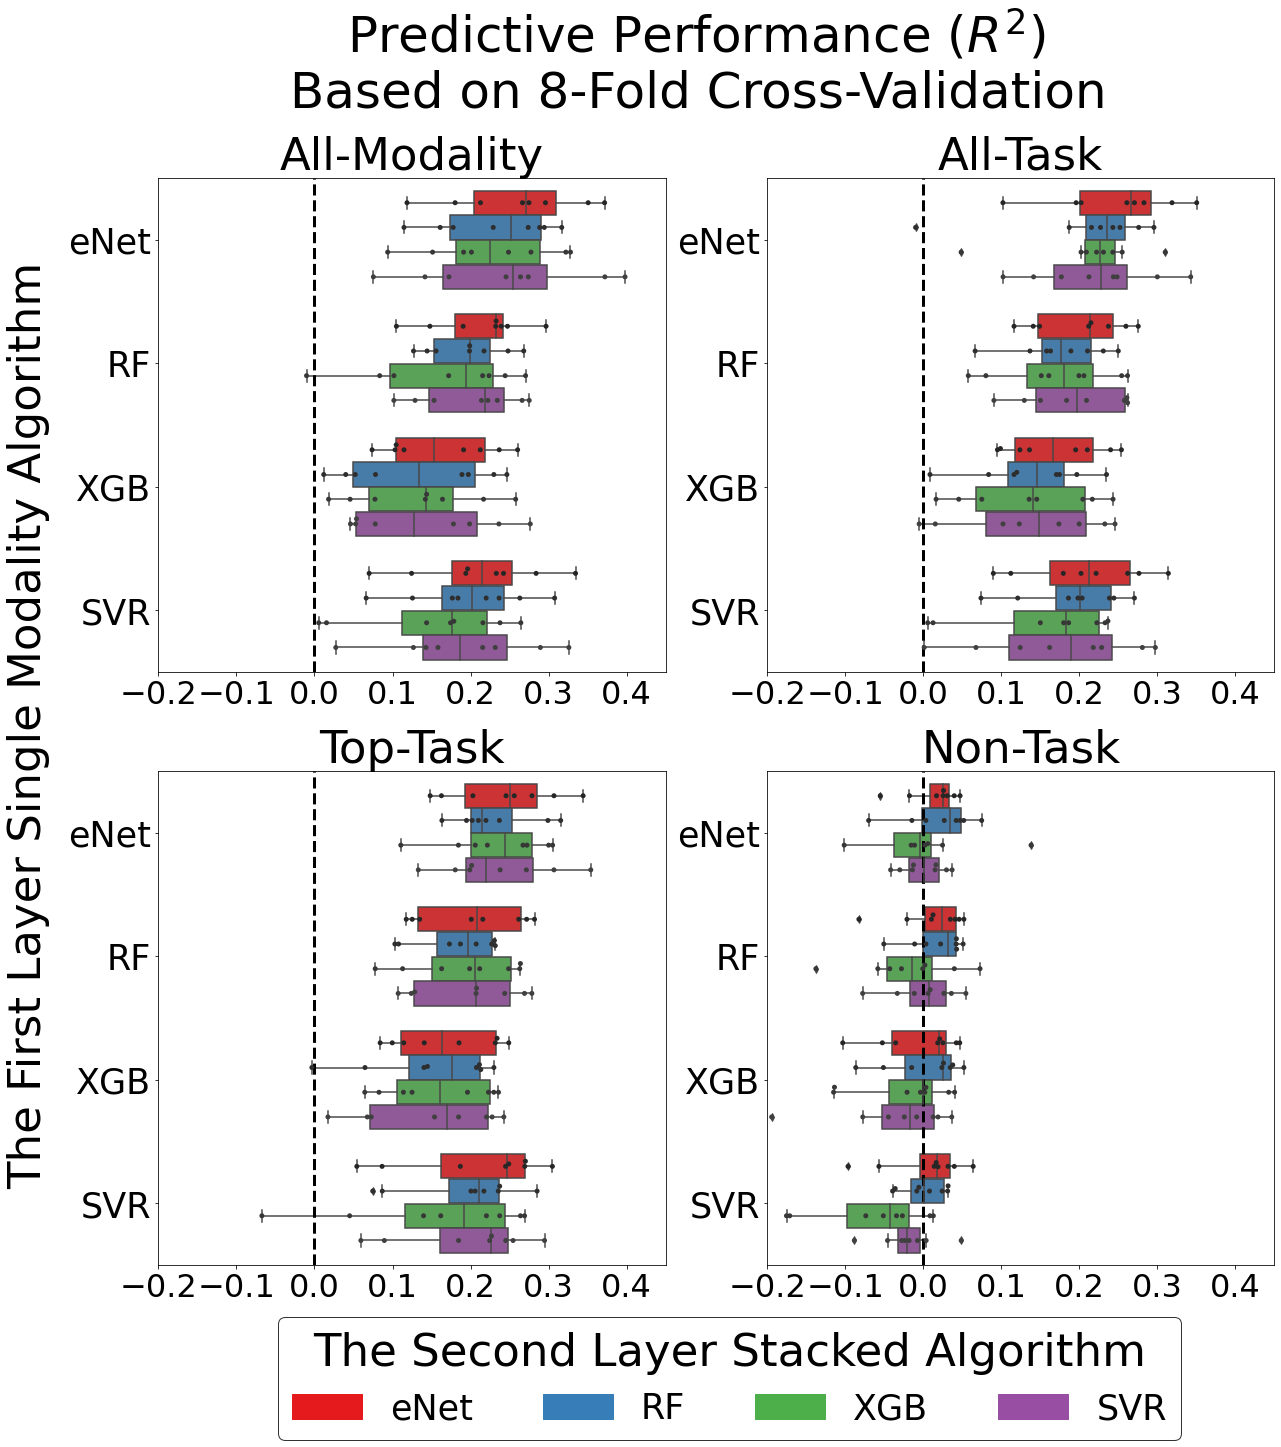

In [27]:
fig = plt.figure(figsize=(20,20))
plt.suptitle('Predictive Performance ($R^2$) \nBased on 8-Fold Cross-Validation',fontsize=50, x=0.5, y=0.999)

font1=28
font2=35
font3=45



plt.subplot(2,2,1)
plt.title('All-Modality', fontsize=45)
sns.boxplot(x='$R^2$', y='Single Modality \nAlgorithm', 
            hue='Stacking Algorithm', 
            data = dct_cv_plot_stacked_r2['all'][dct_cv_plot_stacked_r2['all']['Single Modality \nAlgorithm']!='flat'], 
            orient="h", palette=palette,
            order=['eNet', 'RF', 'XGB','SVR'], hue_order=['eNet', 'RF', 'XGB','SVR'])
sns.swarmplot(x='$R^2$', y='Single Modality \nAlgorithm', 
            hue='Stacking Algorithm', 
            data = dct_cv_plot_stacked_r2['all'][dct_cv_plot_stacked_r2['all']['Single Modality \nAlgorithm']!='flat'], 
            color=".25", orient="h", dodge=True,
            order=['eNet', 'RF', 'XGB','SVR'], hue_order=['eNet', 'RF', 'XGB','SVR'])

plt.legend([], [], frameon=False)

plt.xticks(fontsize=32) # 
plt.yticks(fontsize=35)
plt.xlabel('', fontsize=32)#plt.xlabel('$R^2$', fontsize=32)
plt.ylabel('', fontsize=21)
plt.xlim((-0.2, 0.45))
plt.axvline(0, color='black', linestyle='dashed', linewidth=3)



plt.subplot(2,2,2)
plt.title('All-Task', fontsize=45)
sns.boxplot(x='$R^2$', y='Single Modality \nAlgorithm', 
            hue='Stacking Algorithm', 
            data = dct_cv_plot_stacked_r2['task'][dct_cv_plot_stacked_r2['task']['Single Modality \nAlgorithm']!='flat'], 
            orient="h", palette=palette,
            order=['eNet', 'RF', 'XGB','SVR'], hue_order=['eNet', 'RF', 'XGB','SVR'])
sns.swarmplot(x='$R^2$', y='Single Modality \nAlgorithm', 
            hue='Stacking Algorithm', 
            data = dct_cv_plot_stacked_r2['task'][dct_cv_plot_stacked_r2['task']['Single Modality \nAlgorithm']!='flat'], 
            color=".25", orient="h", dodge=True,
            order=['eNet', 'RF', 'XGB','SVR'], hue_order=['eNet', 'RF', 'XGB','SVR'])

plt.legend([], [], frameon=False)

plt.xticks(fontsize=32) # 
plt.yticks(fontsize=35)
plt.xlabel('', fontsize=32)#plt.xlabel('$R^2$', fontsize=32)
plt.ylabel('', fontsize=21)#plt.ylabel('Modalities', fontsize=21)
plt.xlim((-0.2, 0.45))
plt.axvline(0, color='black', linestyle='dashed', linewidth=3)



plt.subplot(2,2,4)
plt.title('Non-Task', fontsize=45)
sns.boxplot(x='$R^2$', y='Single Modality \nAlgorithm', 
            hue='Stacking Algorithm', 
            data = dct_cv_plot_stacked_r2['non-task'][dct_cv_plot_stacked_r2['non-task']['Single Modality \nAlgorithm']!='flat'], 
            orient="h", palette=palette,
            order=['eNet', 'RF', 'XGB','SVR'], hue_order=['eNet', 'RF', 'XGB','SVR'])
sns.swarmplot(x='$R^2$', y='Single Modality \nAlgorithm', 
            hue='Stacking Algorithm', 
            data = dct_cv_plot_stacked_r2['non-task'][dct_cv_plot_stacked_r2['non-task']['Single Modality \nAlgorithm']!='flat'], 
            color=".25", orient="h", dodge=True,
            order=['eNet', 'RF', 'XGB','SVR'], hue_order=['eNet', 'RF', 'XGB','SVR'])

plt.legend(handles=[mpatches.Patch(color=sns.color_palette("Set1")[0], label='eNet'), 
                    mpatches.Patch(color=sns.color_palette("Set1")[1], label='RF'), 
                    mpatches.Patch(color=sns.color_palette("Set1")[2], label='XGB'), 
                    mpatches.Patch(color=sns.color_palette("Set1")[3], label='SVR')], 
                    fontsize=font2, bbox_to_anchor=(0.85, -0.07), 
                    title="The Second Layer Stacked Algorithm", title_fontsize=font3, ncol=4, edgecolor='black')

plt.xticks(fontsize=32) # 
plt.yticks(fontsize=35)
plt.xlabel('', fontsize=32)#'$R^2$'
plt.ylabel('', fontsize=21)
plt.xlim((-0.2, 0.45))
plt.axvline(0, color='black', linestyle='dashed', linewidth=3)



plt.subplot(2,2,3)
plt.title('Top-Task', fontsize=45)
sns.boxplot(x='$R^2$', y='Single Modality \nAlgorithm', 
            hue='Stacking Algorithm',
            data = dct_cv_plot_stacked_r2['top-task'][dct_cv_plot_stacked_r2['top-task']['Single Modality \nAlgorithm']!='flat'], 
            orient="h", palette=palette,
            order=['eNet', 'RF', 'XGB','SVR'], hue_order=['eNet', 'RF', 'XGB','SVR'])
sns.swarmplot(x='$R^2$', y='Single Modality \nAlgorithm', 
            hue='Stacking Algorithm', 
            data = dct_cv_plot_stacked_r2['top-task'][dct_cv_plot_stacked_r2['top-task']['Single Modality \nAlgorithm']!='flat'], 
            color=".25", orient="h", dodge=True,
            order=['eNet', 'RF', 'XGB','SVR'], hue_order=['eNet', 'RF', 'XGB','SVR'])
plt.legend([], [], frameon=False)


plt.xticks(fontsize=32) # 
plt.yticks(fontsize=35)
plt.xlabel('', fontsize=32)
plt.ylabel('', fontsize=21)#plt.ylabel('Modalities', fontsize=21)
plt.xlim((-0.2, 0.45))
plt.axvline(0, color='black', linestyle='dashed', linewidth=3)

fig.supylabel('The First Layer Single Modality Algorithm', fontsize=45)
#fig.tight_layout(h_pad=2, w_pad=-45)
plt.show()

###### CV single modality models

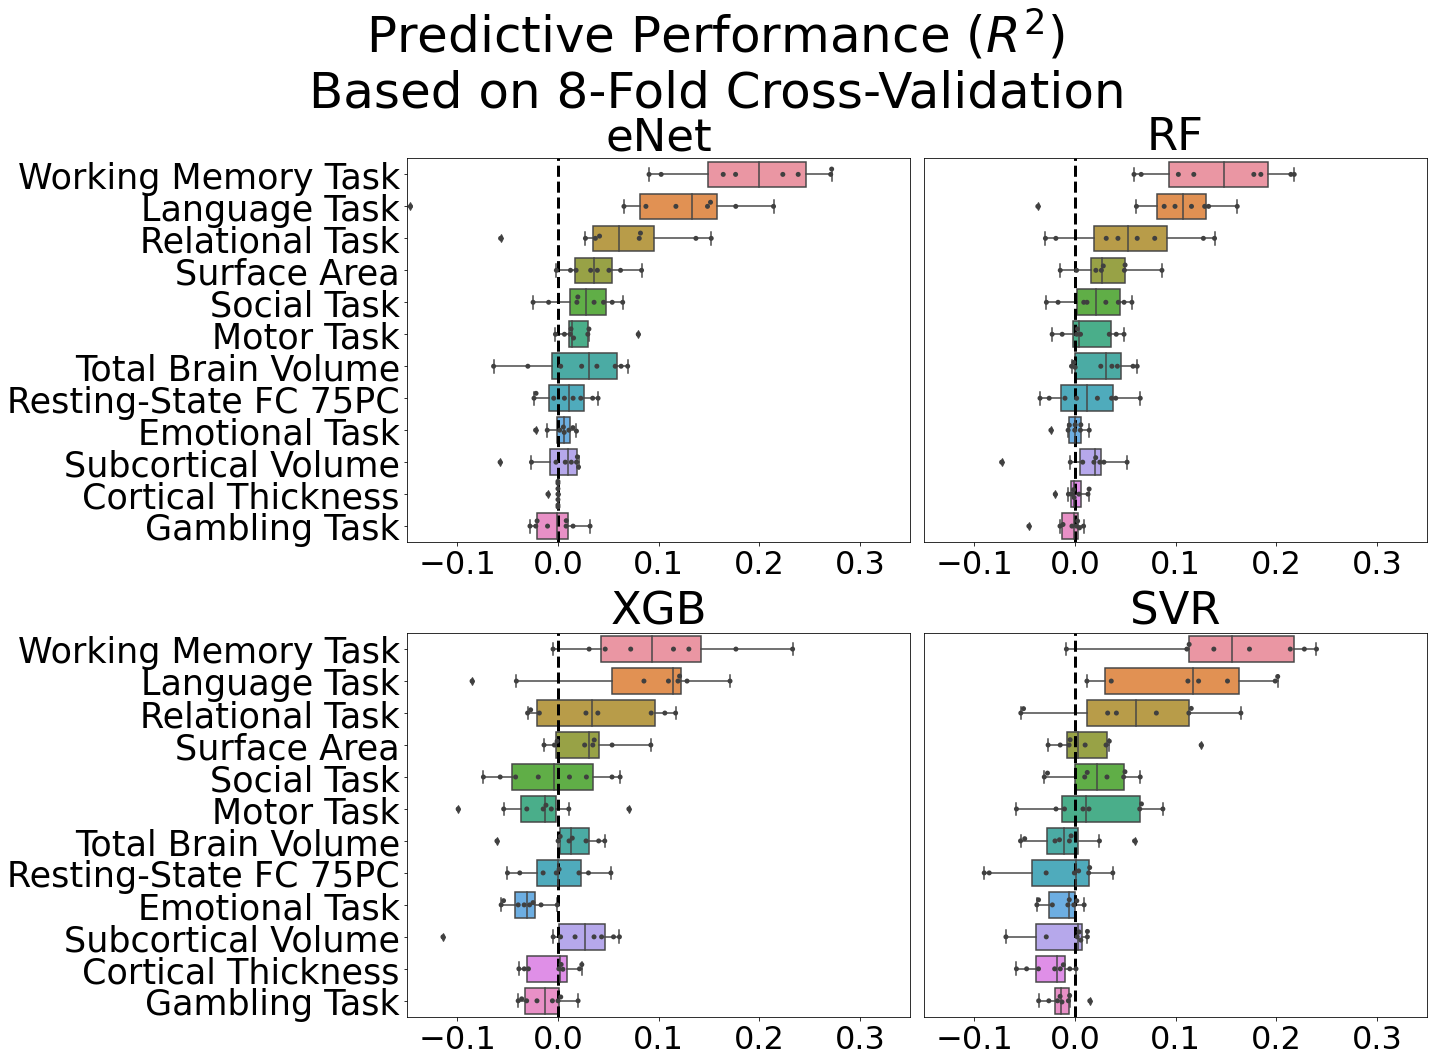

In [28]:
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


fig = plt.figure(figsize=(20,15))
plt.suptitle('Predictive Performance ($R^2$) \nBased on 8-Fold Cross-Validation',fontsize=50)#, x=0.5, y=1.02



font1=28
font2=35
font3=45

lims=(-0.15, 0.35)



col_ord=dct_cv_r2['eNet'].mean().sort_values(ascending=False).index

lblY = ['Working Memory Task',
'Language Task',
'Relational Task',    
'Surface Area',    
'Social Task',    
'Motor Task',     
'Total Brain Volume',
'Resting-State FC 75PC',
'Emotional Task',
'Subcortical Volume',        
'Cortical Thickness',            
'Gambling Task']




plt.subplot(2,2,2)
plt.title('RF', fontsize=45)
sns.boxplot(data = dct_cv_r2['rf'].reindex(columns=col_ord), 
            orient="h")
sns.swarmplot(data = dct_cv_r2['rf'].reindex(columns=col_ord), 
              color=".25", orient="h", dodge=True)

plt.legend([], [], frameon=False)

plt.xticks([-0.1,0,0.1,0.2,0.3],fontsize=32) # 
plt.yticks([], fontsize=35)
plt.xlabel('')#plt.xlabel('$R^2$', fontsize=32)
plt.ylabel('')
plt.xlim(lims)
plt.axvline(0, color='black', linestyle='dashed', linewidth=3)



plt.subplot(2,2,4)
plt.title('SVR', fontsize=45)
sns.boxplot(data = dct_cv_r2['svr'].reindex(columns=col_ord), 
            orient="h")
sns.swarmplot(data = dct_cv_r2['svr'].reindex(columns=col_ord), 
              color=".25", orient="h", dodge=True)

plt.legend([], [], frameon=False)

plt.xticks([-0.1,0,0.1,0.2,0.3],fontsize=32) # 
plt.yticks([],fontsize=35)
plt.xlabel('')#plt.xlabel('$R^2$', fontsize=32)
plt.ylabel('')#plt.ylabel('Modalities', fontsize=21)
plt.xlim(lims)
plt.axvline(0, color='black', linestyle='dashed', linewidth=3)



plt.subplot(2,2,3)
plt.title('XGB', fontsize=45)
sns.boxplot(data = dct_cv_r2['xgb'].reindex(columns=col_ord), 
            orient="h")
sns.swarmplot(data = dct_cv_r2['xgb'].reindex(columns=col_ord), 
              color=".25", orient="h", dodge=True)

plt.legend([], [], frameon=False)

plt.xticks([-0.1,0,0.1,0.2,0.3],fontsize=32) # 
plt.yticks(np.arange(12), lblY, fontsize=35)
plt.xlabel('')#'$R^2$'
plt.ylabel('')
plt.xlim(lims)
plt.axvline(0, color='black', linestyle='dashed', linewidth=3)



plt.subplot(2,2,1)
plt.title('eNet', fontsize=45)
sns.boxplot(data = dct_cv_r2['eNet'].reindex(columns=col_ord), 
            orient="h")
sns.swarmplot(data = dct_cv_r2['eNet'].reindex(columns=col_ord), 
              color=".25", orient="h", dodge=True)
plt.legend([], [], frameon=False)

plt.xticks([-0.1,0,0.1,0.2,0.3],fontsize=32) # 
plt.yticks(np.arange(12), lblY, fontsize=35)
plt.xlabel('')
plt.ylabel('')#plt.ylabel('Modalities', fontsize=21)
plt.xlim(lims)
plt.axvline(0, color='black', linestyle='dashed', linewidth=3)

#fig.supylabel('The First Layer Single Modality Algorithm \n \n \n ', fontsize=50, x=-0.06, y=0.5)
fig.tight_layout(pad=1)
plt.show()

# Bootstrapped difference between "eNet-eNet" All-modality stacked model and others models/algorithms

In [29]:
# r2

#calculate difference between All Mods stacked model (set1) and others
#empty dict for storing results
dct_diff_alg = {}
dct_diff_stack = {}
dct_diff_singl = {}

#doing subtraction
#for algorithms
for key in list(dct_bootstrap_r2.keys())[1:]:
    if len(key.split('+')) >=2:
        dct_diff_alg[('eNet+eNet' + '__-__' + key)] = dct_bootstrap_r2['eNet+eNet']['all'] - dct_bootstrap_r2[key]['all']

#for stacking models in 'eNet+eNet'
for col in dct_bootstrap_r2['eNet+eNet'].columns[1:]:
    dct_diff_stack['all' + '_-_' + col] = dct_bootstrap_r2['eNet+eNet']['all'] - dct_bootstrap_r2['eNet+eNet'][col]

#for single models in 'eNet' and 'eNet+eNet'
for col in dct_bootstrap_r2['eNet'].columns:
    dct_diff_singl['all' + '_-_' + col] = dct_bootstrap_r2['eNet+eNet']['all'] - dct_bootstrap_r2['eNet'][col]

    

#transform dict to tables
diff_alg = pd.DataFrame(dct_diff_alg)
diff_stack = pd.DataFrame(dct_diff_stack)
diff_singl = pd.DataFrame(dct_diff_singl)


In [30]:
# mse

#calculate difference between All Mods stacked model (set1) and others
#empty dict for storing results
dct_diff_alg_mse = {}
dct_diff_stack_mse = {}
dct_diff_singl_mse = {}

#doing subtraction
#for algorithms
for key in list(dct_bootstrap_mse.keys())[1:]:
    if len(key.split('+')) >=2:
        dct_diff_alg_mse[('eNet+eNet' + '__-__' + key)] = dct_bootstrap_mse['eNet+eNet']['all'] - dct_bootstrap_mse[key]['all']

#for stacking models in 'eNet+eNet'
for col in dct_bootstrap_mse['eNet+eNet'].columns[1:]:
    dct_diff_stack_mse['all' + '_-_' + col] = dct_bootstrap_mse['eNet+eNet']['all'] - dct_bootstrap_mse['eNet+eNet'][col]

#for single models in 'eNet' and 'eNet+eNet'
for col in dct_bootstrap_mse['eNet'].columns:
    dct_diff_singl_mse['all' + '_-_' + col] = dct_bootstrap_mse['eNet+eNet']['all'] - dct_bootstrap_mse['eNet'][col]

    

#transform dict to tables
diff_alg_mse = pd.DataFrame(dct_diff_alg_mse)
diff_stack_mse = pd.DataFrame(dct_diff_stack_mse)
diff_singl_mse = pd.DataFrame(dct_diff_singl_mse)


In [31]:
#mae

#calculate difference between All Mods stacked model (set1) and others
#empty dict for storing results
dct_diff_alg_mae = {}
dct_diff_stack_mae = {}
dct_diff_singl_mae = {}

#doing subtraction
#for algorithms
for key in list(dct_bootstrap_mae.keys())[1:]:
    if len(key.split('+')) >=2:
        dct_diff_alg_mae[('eNet+eNet' + '__-__' + key)] = dct_bootstrap_mae['eNet+eNet']['all'] - dct_bootstrap_mae[key]['all']

#for stacking models in 'eNet+eNet'
for col in dct_bootstrap_mae['eNet+eNet'].columns[1:]:
    dct_diff_stack_mae['all' + '_-_' + col] = dct_bootstrap_mae['eNet+eNet']['all'] - dct_bootstrap_mae['eNet+eNet'][col]

#for single models in 'eNet' and 'eNet+eNet'
for col in dct_bootstrap_mae['eNet'].columns:
    dct_diff_singl_mae['all' + '_-_' + col] = dct_bootstrap_mae['eNet+eNet']['all'] - dct_bootstrap_mae['eNet'][col]

    

#transform dict to tables
diff_alg_mae = pd.DataFrame(dct_diff_alg_mae)
diff_stack_mae = pd.DataFrame(dct_diff_stack_mae)
diff_singl_mae = pd.DataFrame(dct_diff_singl_mae)


In [32]:
#cor

#calculate difference between All Mods stacked model (set1) and others
#empty dict for storing results
dct_diff_alg_cor = {}
dct_diff_stack_cor = {}
dct_diff_singl_cor = {}

#doing subtraction
#for algorithms
for key in list(dct_bootstrap_cor.keys())[1:]:
    if len(key.split('+')) >=2:
        dct_diff_alg_cor[('eNet+eNet' + '__-__' + key)] = dct_bootstrap_cor['eNet+eNet']['all'] - dct_bootstrap_cor[key]['all']

#for stacking models in 'eNet+eNet'
for col in dct_bootstrap_cor['eNet+eNet'].columns[1:]:
    dct_diff_stack_cor['all' + '_-_' + col] = dct_bootstrap_cor['eNet+eNet']['all'] - dct_bootstrap_cor['eNet+eNet'][col]

#for single models in 'eNet' and 'eNet+eNet'
for col in dct_bootstrap_cor['eNet'].columns:
    dct_diff_singl_cor['all' + '_-_' + col] = dct_bootstrap_cor['eNet+eNet']['all'] - dct_bootstrap_cor['eNet'][col]

    

#transform dict to tables
diff_alg_cor = pd.DataFrame(dct_diff_alg_cor)
diff_stack_cor = pd.DataFrame(dct_diff_stack_cor)
diff_singl_cor = pd.DataFrame(dct_diff_singl_cor)


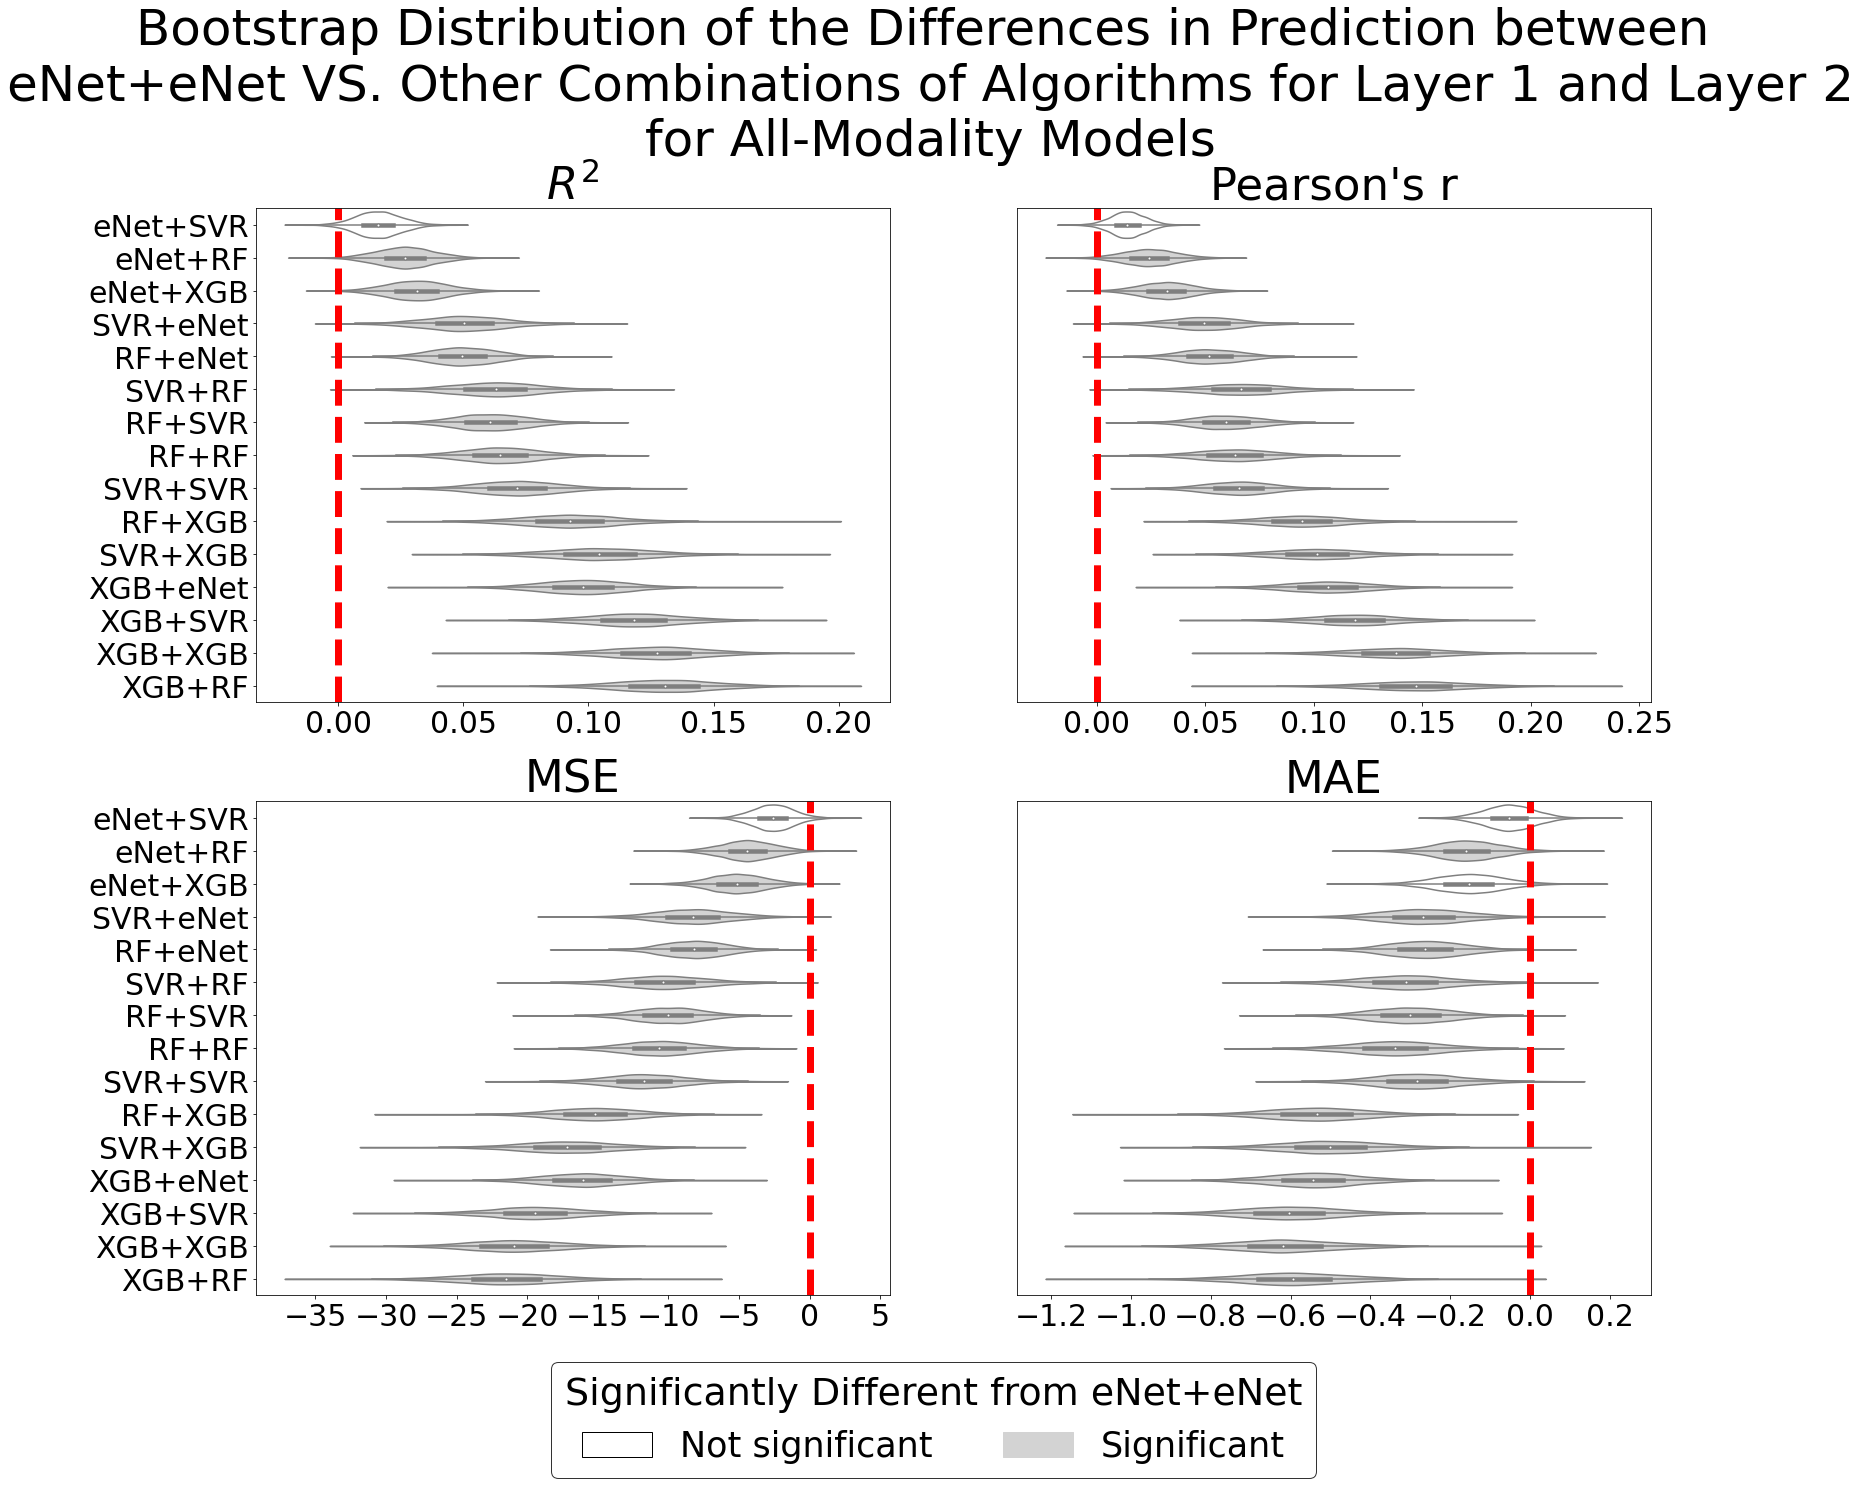

In [33]:
fig = plt.figure(figsize=(25,20))

plt.suptitle('Bootstrap Distribution of the Differences in Prediction between \neNet+eNet VS. Other Combinations of Algorithms for Layer 1 and Layer 2\nfor All-Modality Models',
         fontsize=50, y=1.02)

#dataset for r2
dataset = diff_alg.reindex(columns=[col for col in diff_alg.columns if 'flat' not in col])

CI1, CI2, colss = [],[], []
for col in dataset:
    CI1 += [(st.t.interval(alpha=0.95, df=len(dataset[col])-1, loc=np.mean(dataset[col]), scale=np.std(dataset[col])))[0]]
    CI2 += [(st.t.interval(alpha=0.95, df=len(dataset[col])-1, loc=np.mean(dataset[col]), scale=np.std(dataset[col])))[1]]
    colss += [col]
df_CI1 = pd.DataFrame({'CI1':CI1, 'CI2':CI2}, index=colss).sort_values(by='CI1', ascending=True)

dataset = dataset.reindex(columns=df_CI1.index)


#other indexes datasets
dataset_mse = diff_alg_mse.reindex(columns=df_CI1.index)
dataset_mae = diff_alg_mae.reindex(columns=df_CI1.index)
dataset_cor = diff_alg_cor.reindex(columns=df_CI1.index)

#CI for other datasets indexes (mse, mae, cor)
dct_ci_othinxs={}
algs=['mse', 'mae', 'cor']
c=0
for dtst in [dataset_mse, dataset_mae, dataset_cor]:
    CI1, CI2, colss = [],[], []
    for col in dtst:
        CI1 += [(st.t.interval(alpha=0.95, df=len(dtst[col])-1, loc=np.mean(dtst[col]), scale=np.std(dtst[col])))[0]]
        CI2 += [(st.t.interval(alpha=0.95, df=len(dtst[col])-1, loc=np.mean(dtst[col]), scale=np.std(dtst[col])))[1]]
        colss += [col]
    dct_ci_othinxs[algs[c]]= pd.DataFrame({'CI1':CI1, 'CI2':CI2}, index=colss).sort_values(by='CI1', ascending=True)
    c+=1


#labels for y-axis
ylabl = [col.split('__-__')[1] for col in dataset.columns]

ylabl1=[]
for i in ylabl:
    j = i.split('+')
    if j[0] != 'eNet':
        j[0]=j[0].upper()
    if j[1] != 'eNet':
        j[1]=j[1].upper() 
    ylabl1 += [('+'.join(j))]




        
###plot r2  

plt.subplot(2,2,1)

plt.title("$R^2$", fontsize=45)

#color pallete r2
my_pal = {}
for ind in df_CI1.index:
    if df_CI1.loc[ind, 'CI1'] <=0:
        my_pal[ind] = 'white'
    else:
        my_pal[ind] = 'lightgray'

sns.violinplot(data=dataset, orient='h', palette=my_pal)

plt.axvline(0, color='r', linestyle='dashed', linewidth=7)
#mod=2
#plt.axvline(df_CI1.iloc[mod,0], color='black', linestyle='dashed', linewidth=1)
#plt.axvline(df_CI1.iloc[mod,1], color='black', linestyle='dashed', linewidth=1)
plt.yticks(np.arange(len(ylabl1)), ylabl1, fontsize=30)
plt.xticks(fontsize=30)


###plot mse

plt.subplot(2,2,3)

plt.title("MSE", fontsize=45)

#color pallete mse
my_pal2 = {}
for ind in dct_ci_othinxs['mse'].index:
    if dct_ci_othinxs['mse'].loc[ind, 'CI2'] >=0:
        my_pal2[ind] = 'white'
    else:
        my_pal2[ind] = 'lightgray'

sns.violinplot(data=dataset_mse, orient='h', palette=my_pal2)

#mod=dct_ci_othinxs['mse'].sort_values(by='CI2', ascending=False).index[2]
#plt.axvline(dct_ci_othinxs['mse'].loc[mod,'CI1'], color='black', linestyle='dashed', linewidth=1)
#plt.axvline(dct_ci_othinxs['mse'].loc[mod,'CI2'], color='black', linestyle='dashed', linewidth=1)

plt.axvline(0, color='r', linestyle='dashed', linewidth=7)
plt.yticks(np.arange(len(ylabl1)), ylabl1, fontsize=30)
plt.xticks(fontsize=30)


###plot mae

plt.subplot(2,2,4)

plt.title("MAE", fontsize=45)

#color pallete mae
my_pal3 = {}
for ind in dct_ci_othinxs['mae'].index:
    if dct_ci_othinxs['mae'].loc[ind, 'CI2'] >=0:
        my_pal3[ind] = 'white'
    else:
        my_pal3[ind] = 'lightgray'

sns.violinplot(data=dataset_mae, orient='h', palette=my_pal3)

#mod=dct_ci_othinxs['mae'].sort_values(by='CI2', ascending=False).index[2]
#plt.axvline(dct_ci_othinxs['mae'].loc[mod,'CI1'], color='black', linestyle='dashed', linewidth=1)
#plt.axvline(dct_ci_othinxs['mae'].loc[mod,'CI2'], color='black', linestyle='dashed', linewidth=1)

plt.axvline(0, color='r', linestyle='dashed', linewidth=7)
plt.yticks([])
plt.xticks(fontsize=30)

plt.legend(handles=[mpatches.Patch(edgecolor='black', facecolor='white',  label='Not significant'), 
                    mpatches.Patch(color='lightgray', label='Significant')], 
                    fontsize=35, bbox_to_anchor=(0.5, -0.1), 
                    title="Significantly Different from eNet+eNet", 
           title_fontsize=38, ncol=2, edgecolor='black')


###plot cor

plt.subplot(2,2,2)

plt.title("Pearson's r", fontsize=45)

#color pallete mae
my_pal4 = {}
for ind in dct_ci_othinxs['cor'].index:
    if dct_ci_othinxs['cor'].loc[ind, 'CI1'] <=0:
        my_pal4[ind] = 'white'
    else:
        my_pal4[ind] = 'lightgray'

sns.violinplot(data=dataset_cor, orient='h', palette=my_pal4)

#mod=dct_ci_othinxs['cor'].sort_values(by='CI1', ascending=True).index[2]
#plt.axvline(dct_ci_othinxs['cor'].loc[mod,'CI1'], color='black', linestyle='dashed', linewidth=1)
#plt.axvline(dct_ci_othinxs['cor'].loc[mod,'CI2'], color='black', linestyle='dashed', linewidth=1)

plt.axvline(0, color='r', linestyle='dashed', linewidth=7)
plt.yticks([])
plt.xticks(fontsize=30)




#fig.tight_layout()

plt.show()

In [34]:
df_CI1 #r2

,CI1,CI2
eNet+eNet__-__eNet+svr,-0.001777,0.033823
eNet+eNet__-__eNet+rf,0.004626,0.048863
eNet+eNet__-__eNet+xgb,0.007663,0.055006
eNet+eNet__-__svr+eNet,0.018259,0.082526
eNet+eNet__-__rf+eNet,0.024280,0.075366
eNet+eNet__-__svr+rf,0.028209,0.097139
eNet+eNet__-__rf+svr,0.032927,0.088958
eNet+eNet__-__rf+rf,0.034120,0.095343
eNet+eNet__-__svr+svr,0.038292,0.104699
eNet+eNet__-__rf+xgb,0.055112,0.129963


In [35]:
dct_ci_othinxs['mse'].sort_values(by='CI2', ascending=False)

,CI1,CI2
eNet+eNet__-__eNet+svr,-5.484990,0.246083
eNet+eNet__-__eNet+rf,-8.089638,-0.724972
eNet+eNet__-__eNet+xgb,-9.021542,-1.277978
eNet+eNet__-__svr+eNet,-13.543805,-3.025246
eNet+eNet__-__rf+eNet,-12.475863,-3.933571
eNet+eNet__-__svr+rf,-16.139346,-4.518729
eNet+eNet__-__rf+svr,-14.717573,-5.348569
eNet+eNet__-__rf+rf,-15.887038,-5.453491
eNet+eNet__-__svr+svr,-17.193671,-6.320840
eNet+eNet__-__rf+xgb,-21.323423,-9.106847


In [36]:
dct_ci_othinxs['mae'].sort_values(by='CI2', ascending=False)

,CI1,CI2
eNet+eNet__-__eNet+svr,-0.176568,0.071466
eNet+eNet__-__eNet+xgb,-0.319853,0.013186
eNet+eNet__-__eNet+rf,-0.317733,-0.000291
eNet+eNet__-__svr+eNet,-0.479843,-0.052349
eNet+eNet__-__svr+svr,-0.498645,-0.065106
eNet+eNet__-__rf+eNet,-0.446931,-0.078385
eNet+eNet__-__svr+rf,-0.543509,-0.078859
eNet+eNet__-__rf+svr,-0.499251,-0.100986
eNet+eNet__-__rf+rf,-0.563118,-0.112205
eNet+eNet__-__svr+xgb,-0.760551,-0.241291


In [37]:
dct_ci_othinxs['cor'].sort_values(by='CI1', ascending=True)

,CI1,CI2
eNet+eNet__-__eNet+svr,-0.001442,0.029842
eNet+eNet__-__eNet+rf,0.000297,0.048063
eNet+eNet__-__eNet+xgb,0.008102,0.056153
eNet+eNet__-__svr+eNet,0.017942,0.080991
eNet+eNet__-__rf+eNet,0.024111,0.080035
eNet+eNet__-__svr+rf,0.028306,0.104522
eNet+eNet__-__rf+rf,0.028470,0.098868
eNet+eNet__-__rf+svr,0.030171,0.089183
eNet+eNet__-__svr+svr,0.034110,0.096682
eNet+eNet__-__rf+xgb,0.056488,0.132345


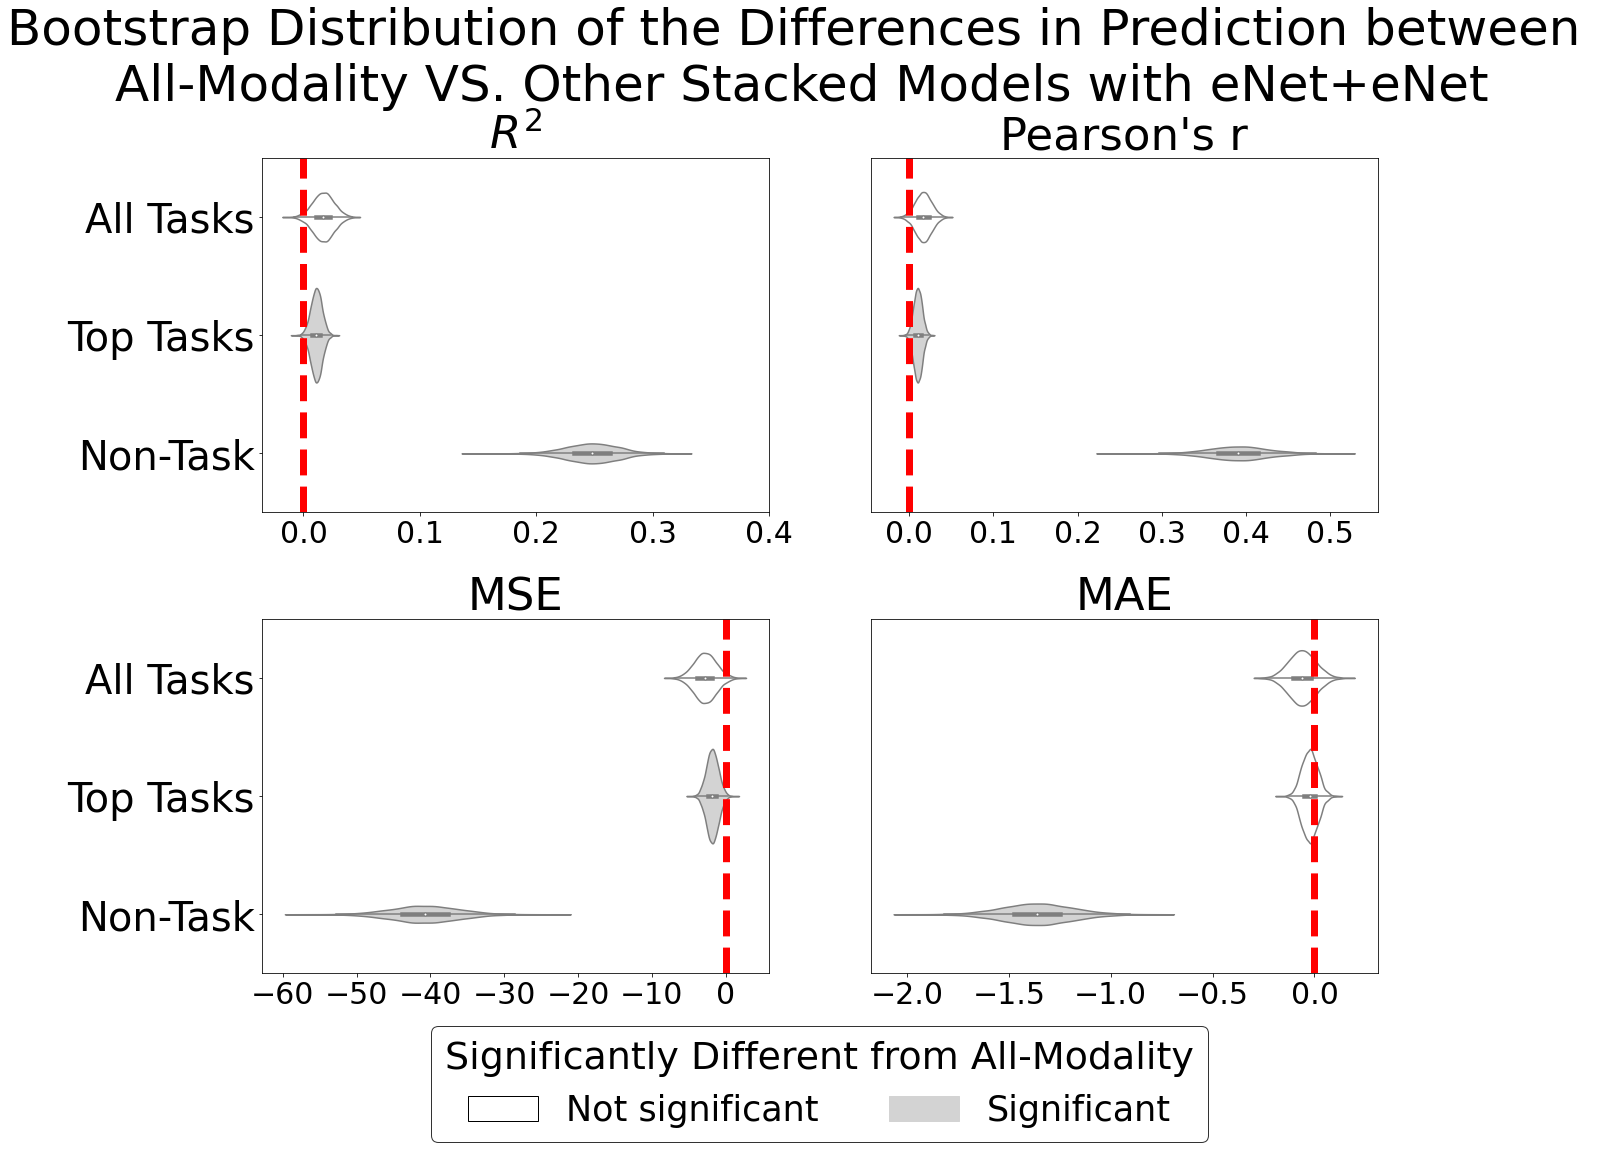

In [38]:
fig = plt.figure(figsize=(20,15))

plt.suptitle('Bootstrap Distribution of the Differences in Prediction between \nAll-Modality VS. Other Stacked Models with eNet+eNet',
         fontsize=50, y=1.02)

#dataset for r2
dataset = diff_stack.reindex(columns=[col for col in diff_stack.columns if 'flat' not in col])

CI1, CI2, colss = [],[], []
for col in dataset:
    CI1 += [(st.t.interval(alpha=0.95, df=len(dataset[col])-1, loc=np.mean(dataset[col]), scale=np.std(dataset[col])))[0]]
    CI2 += [(st.t.interval(alpha=0.95, df=len(dataset[col])-1, loc=np.mean(dataset[col]), scale=np.std(dataset[col])))[1]]
    colss += [col]
df_CI2 = pd.DataFrame({'CI1':CI1, 'CI2':CI2}, index=colss).sort_values(by='CI1', ascending=True)

dataset = dataset.reindex(columns=df_CI2.index)


#other indexes datasets
dataset_mse = diff_stack_mse.reindex(columns=df_CI2.index)
dataset_mae = diff_stack_mae.reindex(columns=df_CI2.index)
dataset_cor = diff_stack_cor.reindex(columns=df_CI2.index)

#CI for other datasets indexes (mse, mae, cor)
dct_ci_othinxs2={}
algs=['mse', 'mae', 'cor']
c=0
for dtst in [dataset_mse, dataset_mae, dataset_cor]:
    CI1, CI2, colss = [],[], []
    for col in dtst:
        CI1 += [(st.t.interval(alpha=0.95, df=len(dtst[col])-1, loc=np.mean(dtst[col]), scale=np.std(dtst[col])))[0]]
        CI2 += [(st.t.interval(alpha=0.95, df=len(dtst[col])-1, loc=np.mean(dtst[col]), scale=np.std(dtst[col])))[1]]
        colss += [col]
    dct_ci_othinxs2[algs[c]]= pd.DataFrame({'CI1':CI1, 'CI2':CI2}, index=colss).sort_values(by='CI1', ascending=True)
    c+=1


#labels for y-axis
ylabl = ['All Tasks',
        'Top Tasks',
        'Non-Task']

        
###plot r2  

plt.subplot(2,2,1)

plt.title("$R^2$", fontsize=45)

#color pallete r2
my_pal = {}
for ind in df_CI2.index:
    if df_CI2.loc[ind, 'CI1'] <=0:
        my_pal[ind] = 'white'
    else:
        my_pal[ind] = 'lightgray'

sns.violinplot(data=dataset, orient='h', palette=my_pal)

plt.axvline(0, color='r', linestyle='dashed', linewidth=7)
#mod=0
#plt.axvline(df_CI2.iloc[mod,0], color='black', linestyle='dashed', linewidth=1)
#plt.axvline(df_CI2.iloc[mod,1], color='black', linestyle='dashed', linewidth=1)
plt.yticks(np.arange(len(ylabl)), ylabl, fontsize=40)
plt.xticks([0,0.1,0.2,0.3,0.4],fontsize=30)


###plot mse

plt.subplot(2,2,3)

plt.title("MSE", fontsize=45)

#color pallete mse
my_pal2 = {}
for ind in dct_ci_othinxs2['mse'].index:
    if dct_ci_othinxs2['mse'].loc[ind, 'CI2'] >=0:
        my_pal2[ind] = 'white'
    else:
        my_pal2[ind] = 'lightgray'

sns.violinplot(data=dataset_mse, orient='h', palette=my_pal2)

#mod=dct_ci_othinxs2['mse'].sort_values(by='CI2', ascending=False).index[0]
#plt.axvline(dct_ci_othinxs2['mse'].loc[mod,'CI1'], color='black', linestyle='dashed', linewidth=1)
#plt.axvline(dct_ci_othinxs2['mse'].loc[mod,'CI2'], color='black', linestyle='dashed', linewidth=1)

plt.axvline(0, color='r', linestyle='dashed', linewidth=7)
plt.yticks(np.arange(len(ylabl)), ylabl, fontsize=40)
plt.xticks(fontsize=30)


###plot mae

plt.subplot(2,2,4)

plt.title("MAE", fontsize=45)

#color pallete mae
my_pal3 = {}
for ind in dct_ci_othinxs2['mae'].index:
    if dct_ci_othinxs2['mae'].loc[ind, 'CI2'] >=0:
        my_pal3[ind] = 'white'
    else:
        my_pal3[ind] = 'lightgray'

sns.violinplot(data=dataset_mae, orient='h', palette=my_pal3)

#mod=dct_ci_othinxs2['mae'].sort_values(by='CI2', ascending=False).index[2]
#plt.axvline(dct_ci_othinxs2['mae'].loc[mod,'CI1'], color='black', linestyle='dashed', linewidth=1)
#plt.axvline(dct_ci_othinxs2['mae'].loc[mod,'CI2'], color='black', linestyle='dashed', linewidth=1)

plt.axvline(0, color='r', linestyle='dashed', linewidth=7)
plt.yticks([])
plt.xticks(fontsize=30)

plt.legend(handles=[mpatches.Patch(edgecolor='black', facecolor='white',  label='Not significant'), 
                    mpatches.Patch(color='lightgray', label='Significant')], 
                    fontsize=35, bbox_to_anchor=(0.7, -0.1), 
                    title="Significantly Different from All-Modality", 
           title_fontsize=38, ncol=2, edgecolor='black')
###plot cor

plt.subplot(2,2,2)

plt.title("Pearson's r", fontsize=45)

#color pallete mae
my_pal4 = {}
for ind in dct_ci_othinxs2['cor'].index:
    if dct_ci_othinxs2['cor'].loc[ind, 'CI1'] <=0:
        my_pal4[ind] = 'white'
    else:
        my_pal4[ind] = 'lightgray'

sns.violinplot(data=dataset_cor, orient='h', palette=my_pal4)

#mod=dct_ci_othinxs2['cor'].sort_values(by='CI1', ascending=True).index[0]
#plt.axvline(dct_ci_othinxs2['cor'].loc[mod,'CI1'], color='black', linestyle='dashed', linewidth=1)
#plt.axvline(dct_ci_othinxs2['cor'].loc[mod,'CI2'], color='black', linestyle='dashed', linewidth=1)

plt.axvline(0, color='r', linestyle='dashed', linewidth=7)
plt.yticks([])
plt.xticks(fontsize=30)

#fig.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.show()

In [39]:
df_CI2 #r2

,CI1,CI2
all_-_top-task,-0.001006,0.034805
all_-_task,0.001512,0.020383
all_-_non-task,0.202620,0.292535


In [40]:
dct_ci_othinxs2['mse']

,CI1,CI2
all_-_non-task,-49.763157,-31.842955
all_-_top-task,-5.748449,0.177607
all_-_task,-3.408291,-0.214471


In [41]:
dct_ci_othinxs2['mae']

,CI1,CI2
all_-_non-task,-1.700902,-1.023822
all_-_top-task,-0.190323,0.068972
all_-_task,-0.100698,0.053113


In [42]:
dct_ci_othinxs2['cor']

,CI1,CI2
all_-_top-task,-0.002164,0.035805
all_-_task,0.000265,0.020138
all_-_non-task,0.321268,0.459723


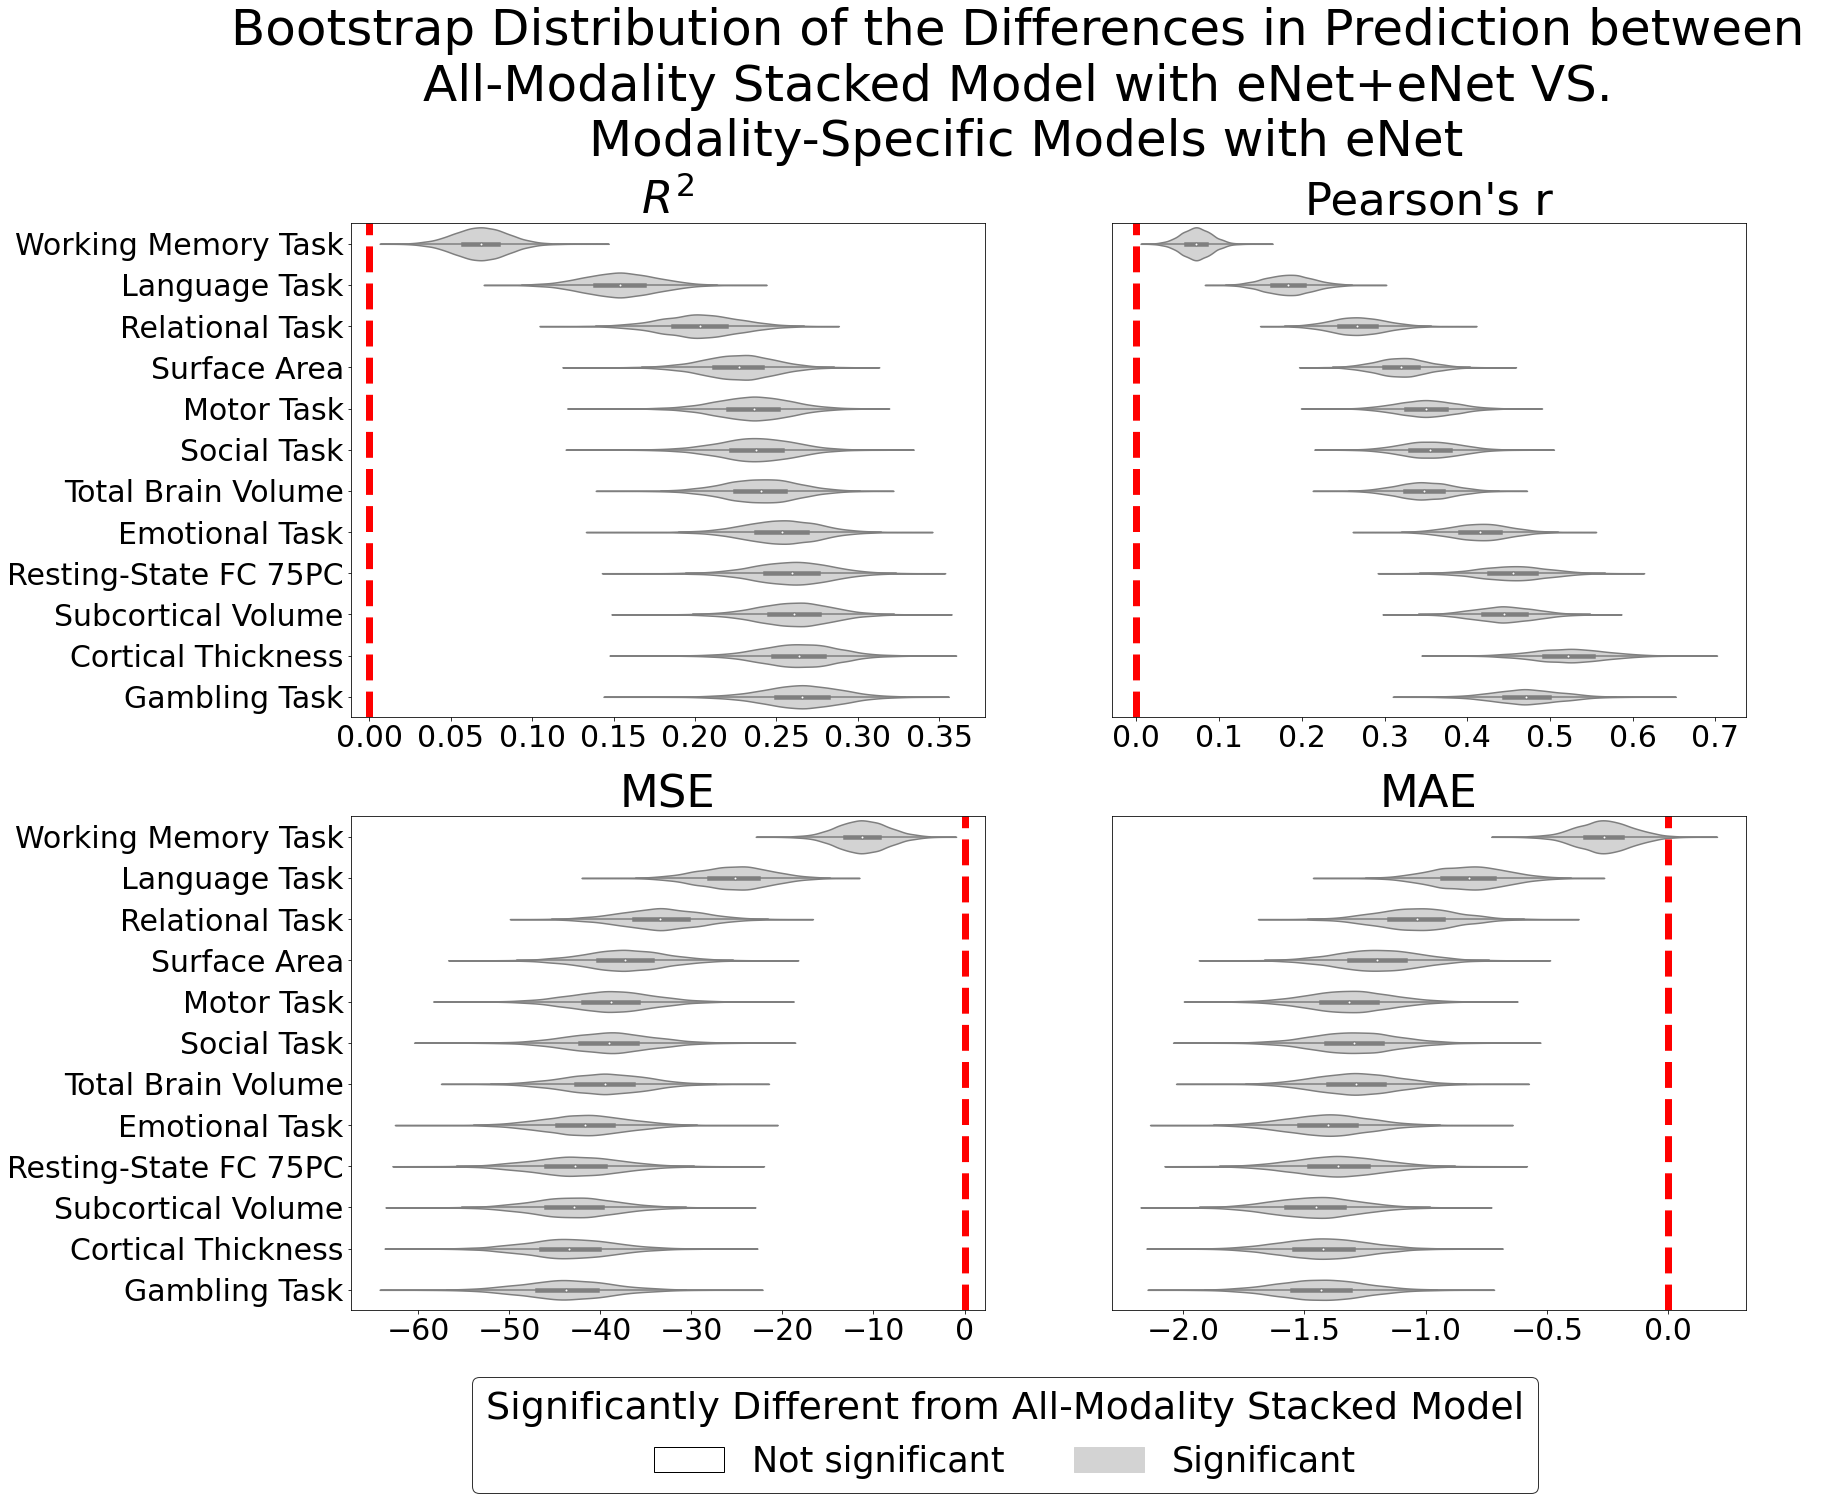

In [43]:

fig = plt.figure(figsize=(25,20))

plt.suptitle('Bootstrap Distribution of the Differences in Prediction between \nAll-Modality Stacked Model with eNet+eNet VS. \nModality-Specific Models with eNet',
         fontsize=50, y=1.03)

#dataset for r2
dataset = diff_singl.reindex(columns=[col for col in diff_singl.columns if 'flat' not in col])

CI1, CI2, colss = [],[], []
for col in dataset:
    CI1 += [(st.t.interval(alpha=0.95, df=len(dataset[col])-1, loc=np.mean(dataset[col]), scale=np.std(dataset[col])))[0]]
    CI2 += [(st.t.interval(alpha=0.95, df=len(dataset[col])-1, loc=np.mean(dataset[col]), scale=np.std(dataset[col])))[1]]
    colss += [col]
df_CI3 = pd.DataFrame({'CI1':CI1, 'CI2':CI2}, index=colss).sort_values(by='CI1', ascending=True)

dataset = dataset.reindex(columns=df_CI3.index)


#other indexes datasets
dataset_mse = diff_singl_mse.reindex(columns=df_CI3.index)
dataset_mae = diff_singl_mae.reindex(columns=df_CI3.index)
dataset_cor = diff_singl_cor.reindex(columns=df_CI3.index)

#CI for other datasets indexes (mse, mae, cor)
dct_ci_othinxs3={}
algs=['mse', 'mae', 'cor']
c=0
for dtst in [dataset_mse, dataset_mae, dataset_cor]:
    CI1, CI2, colss = [],[], []
    for col in dtst:
        CI1 += [(st.t.interval(alpha=0.95, df=len(dtst[col])-1, loc=np.mean(dtst[col]), scale=np.std(dtst[col])))[0]]
        CI2 += [(st.t.interval(alpha=0.95, df=len(dtst[col])-1, loc=np.mean(dtst[col]), scale=np.std(dtst[col])))[1]]
        colss += [col]
    dct_ci_othinxs3[algs[c]]= pd.DataFrame({'CI1':CI1, 'CI2':CI2}, index=colss).sort_values(by='CI1', ascending=True)
    c+=1


#labels for y-axis
ylabl = ['Working Memory Task',
 'Language Task',
 'Relational Task',
 'Surface Area',
 'Motor Task', 
 'Social Task',
 'Total Brain Volume',
 'Emotional Task', 
 'Resting-State FC 75PC',
 'Subcortical Volume',
 'Cortical Thickness',
 'Gambling Task']

        
###plot r2  

plt.subplot(2,2,1)

plt.title("$R^2$", fontsize=45)

#color pallete r2
my_pal = {}
for ind in df_CI3.index:
    if df_CI3.loc[ind, 'CI1'] <=0:
        my_pal[ind] = 'white'
    else:
        my_pal[ind] = 'lightgray'

sns.violinplot(data=dataset, orient='h', palette=my_pal)

plt.axvline(0, color='r', linestyle='dashed', linewidth=7)
#mod=0
#plt.axvline(df_CI3.iloc[mod,0], color='black', linestyle='dashed', linewidth=1)
#plt.axvline(df_CI3.iloc[mod,1], color='black', linestyle='dashed', linewidth=1)
plt.yticks(np.arange(len(ylabl)), ylabl, fontsize=30)
plt.xticks(fontsize=30)


###plot mse

plt.subplot(2,2,3)

plt.title("MSE", fontsize=45)

#color pallete mse
my_pal2 = {}
for ind in dct_ci_othinxs3['mse'].index:
    if dct_ci_othinxs3['mse'].loc[ind, 'CI2'] >=0:
        my_pal2[ind] = 'white'
    else:
        my_pal2[ind] = 'lightgray'

sns.violinplot(data=dataset_mse, orient='h', palette=my_pal2)

#mod=dct_ci_othinxs3['mse'].sort_values(by='CI2', ascending=False).index[0]
#plt.axvline(dct_ci_othinxs3['mse'].loc[mod,'CI1'], color='black', linestyle='dashed', linewidth=1)
#plt.axvline(dct_ci_othinxs3['mse'].loc[mod,'CI2'], color='black', linestyle='dashed', linewidth=1)

plt.axvline(0, color='r', linestyle='dashed', linewidth=7)
plt.yticks(np.arange(len(ylabl)), ylabl, fontsize=30)
plt.xticks(fontsize=30)


###plot mae

plt.subplot(2,2,4)

plt.title("MAE", fontsize=45)

#color pallete mae
my_pal3 = {}
for ind in dct_ci_othinxs3['mae'].index:
    if dct_ci_othinxs3['mae'].loc[ind, 'CI2'] >=0:
        my_pal3[ind] = 'white'
    else:
        my_pal3[ind] = 'lightgray'

sns.violinplot(data=dataset_mae, orient='h', palette=my_pal3)

#mod=dct_ci_othinxs3['mae'].sort_values(by='CI2', ascending=False).index[0]
#plt.axvline(dct_ci_othinxs3['mae'].loc[mod,'CI1'], color='black', linestyle='dashed', linewidth=1)
#plt.axvline(dct_ci_othinxs3['mae'].loc[mod,'CI2'], color='black', linestyle='dashed', linewidth=1)

plt.axvline(0, color='r', linestyle='dashed', linewidth=7)
plt.yticks([])
plt.xticks(fontsize=30)

plt.legend(handles=[mpatches.Patch(edgecolor='black', facecolor='white',  label='Not significant'), 
                    mpatches.Patch(color='lightgray', label='Significant')], 
                    fontsize=35, bbox_to_anchor=(0.7, -0.1), 
                    title="Significantly Different from All-Modality Stacked Model", 
           title_fontsize=38, ncol=2, edgecolor='black')
###plot cor

plt.subplot(2,2,2)

plt.title("Pearson's r", fontsize=45)

#color pallete mae
my_pal4 = {}
for ind in dct_ci_othinxs3['cor'].index:
    if dct_ci_othinxs3['cor'].loc[ind, 'CI1'] <=0:
        my_pal4[ind] = 'white'
    else:
        my_pal4[ind] = 'lightgray'

sns.violinplot(data=dataset_cor, orient='h', palette=my_pal4)

#mod=dct_ci_othinxs3['cor'].sort_values(by='CI1', ascending=True).index[0]
#plt.axvline(dct_ci_othinxs3['cor'].loc[mod,'CI1'], color='black', linestyle='dashed', linewidth=1)
#plt.axvline(dct_ci_othinxs3['cor'].loc[mod,'CI2'], color='black', linestyle='dashed', linewidth=1)

plt.axvline(0, color='r', linestyle='dashed', linewidth=7)
plt.yticks([])
plt.xticks(fontsize=30)





#fig.tight_layout()

plt.show()

In [44]:
df_CI3 #r2

,CI1,CI2
all_-_wm,0.036372,0.100091
all_-_lan,0.110566,0.197024
all_-_rel,0.156093,0.249491
all_-_soc,0.182887,0.269674
all_-_surf,0.190513,0.280859
all_-_mot,0.190859,0.283519
all_-_emo,0.195424,0.284508
all_-_VolBrain,0.207607,0.298053
all_-_cort,0.212408,0.306087
all_-_subc,0.215115,0.305714


In [45]:
dct_ci_othinxs3['mse']

,CI1,CI2
all_-_rest-pca75,-53.350121,-34.077485
all_-_gam,-52.904964,-33.913664
all_-_cort,-52.322675,-33.157255
all_-_subc,-52.123175,-33.719364
all_-_VolBrain,-50.793837,-32.550831
all_-_emo,-48.537482,-30.578409
all_-_mot,-48.231132,-29.963493
all_-_surf,-47.727884,-29.961694
all_-_soc,-46.082459,-28.536376
all_-_rel,-42.155329,-24.689391


In [46]:
dct_ci_othinxs3['mae']

,CI1,CI2
all_-_subc,-1.800590,-1.107656
all_-_rest-pca75,-1.781318,-1.081429
all_-_gam,-1.769990,-1.071113
all_-_VolBrain,-1.745750,-1.060777
all_-_cort,-1.715374,-1.005769
all_-_surf,-1.650936,-0.981352
all_-_mot,-1.634987,-0.955597
all_-_emo,-1.619413,-0.954278
all_-_soc,-1.534145,-0.865089
all_-_rel,-1.367522,-0.711593


In [47]:
dct_ci_othinxs3['cor']

,CI1,CI2
all_-_wm,0.036196,0.108108
all_-_lan,0.127889,0.239701
all_-_rel,0.202731,0.332978
all_-_soc,0.258200,0.382095
all_-_surf,0.280441,0.419415
all_-_emo,0.282536,0.413439
all_-_mot,0.284863,0.425015
all_-_VolBrain,0.345046,0.485336
all_-_subc,0.371368,0.518553
all_-_cort,0.372727,0.536760


# Bootstrapped difference between "eNet-eNet" All-TASK stacked model and others models/algorithms

In [48]:

#calculate difference between All-Task stacked model (set1) and others
#empty dict for storing results
dct_diff_stack_T = {}
dct_diff_stack_mse_T = {}
dct_diff_stack_mae_T = {}
dct_diff_stack_cor_T = {}

#for stacking models in 'eNet+eNet'
for col in dct_bootstrap_r2['eNet+eNet'].reindex(columns=['all', 'non-task', 'top-task']).columns:
    dct_diff_stack_T['task' + '_-_' + col] = dct_bootstrap_r2['eNet+eNet']['task'] - dct_bootstrap_r2['eNet+eNet'][col]
    
#for stacking models in 'eNet+eNet'
for col in dct_bootstrap_mse['eNet+eNet'].reindex(columns=['all', 'non-task', 'top-task']).columns:
    dct_diff_stack_mse_T['task' + '_-_' + col] = dct_bootstrap_mse['eNet+eNet']['task'] - dct_bootstrap_mse['eNet+eNet'][col]

#for stacking models in 'eNet+eNet'
for col in dct_bootstrap_mae['eNet+eNet'].reindex(columns=['all', 'non-task', 'top-task']).columns:
    dct_diff_stack_mae_T['task' + '_-_' + col] = dct_bootstrap_mae['eNet+eNet']['task'] - dct_bootstrap_mae['eNet+eNet'][col]

#for stacking models in 'eNet+eNet'
for col in dct_bootstrap_cor['eNet+eNet'].reindex(columns=['all', 'non-task', 'top-task']).columns:
    dct_diff_stack_cor_T['task' + '_-_' + col] = dct_bootstrap_cor['eNet+eNet']['task'] - dct_bootstrap_cor['eNet+eNet'][col]


#transform dict to tables
diff_stack_T = pd.DataFrame(dct_diff_stack_T)    
diff_stack_mse_T = pd.DataFrame(dct_diff_stack_mse_T)
diff_stack_mae_T = pd.DataFrame(dct_diff_stack_mae_T)
diff_stack_cor_T = pd.DataFrame(dct_diff_stack_cor_T)


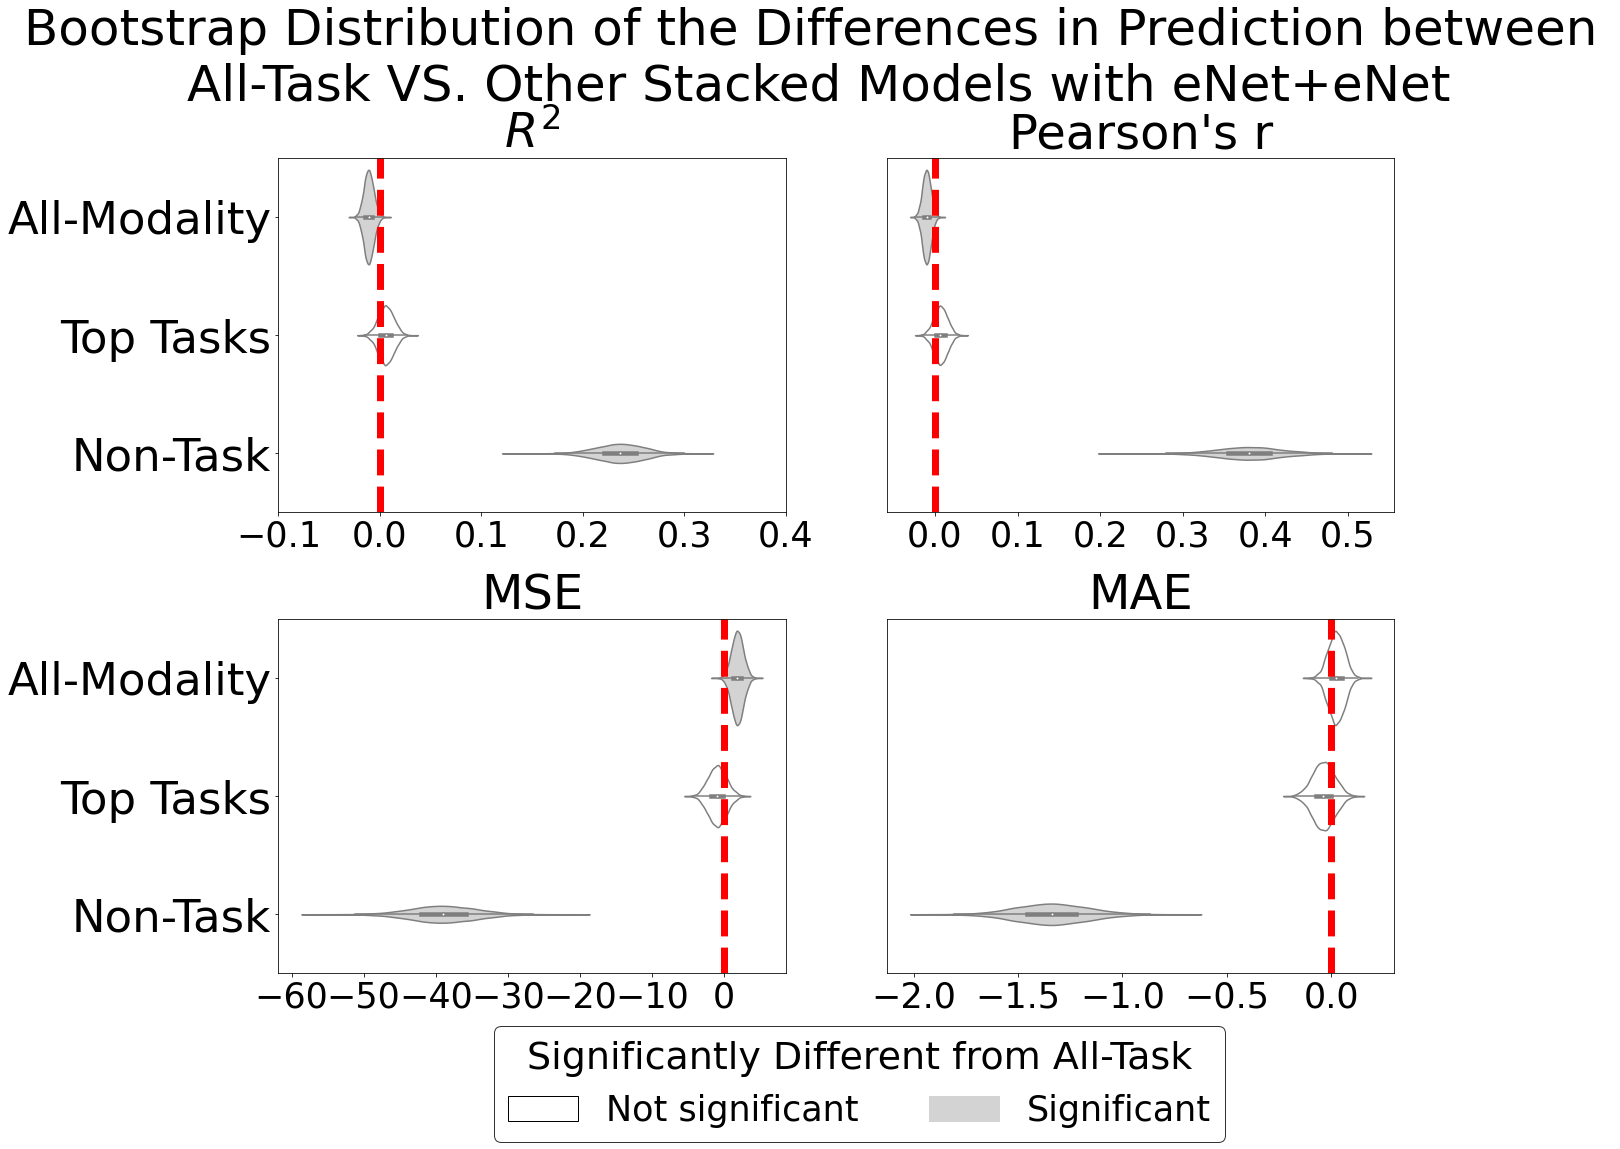

In [61]:
fig = plt.figure(figsize=(20,15))

plt.suptitle('Bootstrap Distribution of the Differences in Prediction between \nAll-Task VS. Other Stacked Models with eNet+eNet',
         fontsize=50, y=1.02)#

#dataset for r2
dataset = diff_stack_T.reindex(columns=[col for col in diff_stack_T.columns if 'flat' not in col])

CI1, CI2, colss = [],[], []
for col in dataset:
    CI1 += [(st.t.interval(alpha=0.95, df=len(dataset[col])-1, loc=np.mean(dataset[col]), scale=np.std(dataset[col])))[0]]
    CI2 += [(st.t.interval(alpha=0.95, df=len(dataset[col])-1, loc=np.mean(dataset[col]), scale=np.std(dataset[col])))[1]]
    colss += [col]
df_CI2 = pd.DataFrame({'CI1':CI1, 'CI2':CI2}, index=colss).sort_values(by='CI1', ascending=True)

dataset = dataset.reindex(columns=df_CI2.index)


#other indexes datasets
dataset_mse = diff_stack_mse_T.reindex(columns=df_CI2.index)
dataset_mae = diff_stack_mae_T.reindex(columns=df_CI2.index)
dataset_cor = diff_stack_cor_T.reindex(columns=df_CI2.index)

#CI for other datasets indexes (mse, mae, cor)
dct_ci_othinxs2={}
algs=['mse', 'mae', 'cor']
c=0
for dtst in [dataset_mse, dataset_mae, dataset_cor]:
    CI1, CI2, colss = [],[], []
    for col in dtst:
        CI1 += [(st.t.interval(alpha=0.95, df=len(dtst[col])-1, loc=np.mean(dtst[col]), scale=np.std(dtst[col])))[0]]
        CI2 += [(st.t.interval(alpha=0.95, df=len(dtst[col])-1, loc=np.mean(dtst[col]), scale=np.std(dtst[col])))[1]]
        colss += [col]
    dct_ci_othinxs2[algs[c]]= pd.DataFrame({'CI1':CI1, 'CI2':CI2}, index=colss).sort_values(by='CI1', ascending=True)
    c+=1


#labels for y-axis
ylabl = ['All-Modality',
        'Top Tasks',
        'Non-Task']

        
###plot r2  

plt.subplot(2,2,1)

plt.title("$R^2$", fontsize=48)

#color pallete r2
my_pal = {}
for ind in df_CI2.index:
    if df_CI2.loc[ind, 'CI1'] <0 and df_CI2.loc[ind, 'CI2']<0:
        my_pal[ind] = 'lightgray'
    if df_CI2.loc[ind, 'CI1'] <0 and df_CI2.loc[ind, 'CI2']>0:
        my_pal[ind] = 'white'
    else:
        my_pal[ind] = 'lightgray'

sns.violinplot(data=dataset, orient='h', palette=my_pal)

plt.axvline(0, color='r', linestyle='dashed', linewidth=7)
#mod=2
#plt.axvline(df_CI2.iloc[mod,0], color='black', linestyle='dashed', linewidth=1)
#plt.axvline(df_CI2.iloc[mod,1], color='black', linestyle='dashed', linewidth=1)
plt.yticks(np.arange(len(ylabl)), ylabl, fontsize=45)
plt.xticks([-0.1,0,0.1,0.2,0.3,0.4], fontsize=35)


###plot mse

plt.subplot(2,2,3)

plt.title("MSE", fontsize=48)

#color pallete mse
my_pal2 = {}
for ind in dct_ci_othinxs2['mse'].index:
    if dct_ci_othinxs2['mse'].loc[ind, 'CI1'] >0 and dct_ci_othinxs2['mse'].loc[ind, 'CI2']>0:
        my_pal2[ind] = 'lightgray'
    if dct_ci_othinxs2['mse'].loc[ind, 'CI1'] <0 and dct_ci_othinxs2['mse'].loc[ind, 'CI2']>0:
        my_pal2[ind] = 'white'

    else:
        my_pal2[ind] = 'lightgray'

sns.violinplot(data=dataset_mse, orient='h', palette=my_pal2)

#mod=dct_ci_othinxs2['mse'].sort_values(by='CI2', ascending=False).index[2]
#plt.axvline(dct_ci_othinxs2['mse'].loc[mod,'CI1'], color='black', linestyle='dashed', linewidth=1)
#plt.axvline(dct_ci_othinxs2['mse'].loc[mod,'CI2'], color='black', linestyle='dashed', linewidth=1)

plt.axvline(0, color='r', linestyle='dashed', linewidth=7)
plt.yticks(np.arange(len(ylabl)), ylabl, fontsize=45)
plt.xticks(fontsize=35)


###plot mae

plt.subplot(2,2,4)

plt.title("MAE", fontsize=48)

#color pallete mae
my_pal3 = {}
for ind in dct_ci_othinxs2['mae'].index:        
    if dct_ci_othinxs2['mae'].loc[ind, 'CI1'] >0 and dct_ci_othinxs2['mae'].loc[ind, 'CI2'] >0:
        my_pal3[ind] = 'lightgray'
    if dct_ci_othinxs2['mae'].loc[ind, 'CI1'] <0 and dct_ci_othinxs2['mae'].loc[ind, 'CI2'] >0:
        my_pal3[ind] = 'white'

    else:
        my_pal3[ind] = 'lightgray'

sns.violinplot(data=dataset_mae, orient='h', palette=my_pal3)

#mod=dct_ci_othinxs2['mae'].sort_values(by='CI2', ascending=False).index[2]
#plt.axvline(dct_ci_othinxs2['mae'].loc[mod,'CI1'], color='black', linestyle='dashed', linewidth=1)
#plt.axvline(dct_ci_othinxs2['mae'].loc[mod,'CI2'], color='black', linestyle='dashed', linewidth=1)

plt.axvline(0, color='r', linestyle='dashed', linewidth=7)
plt.yticks([])
plt.xticks(fontsize=35)

plt.legend(handles=[mpatches.Patch(edgecolor='black', facecolor='white',  label='Not significant'), 
                    mpatches.Patch(color='lightgray', label='Significant')], 
                    fontsize=35, bbox_to_anchor=(0.7, -0.1), 
                    title="Significantly Different from All-Task", 
           title_fontsize=38, ncol=2, edgecolor='black')

###plot cor

plt.subplot(2,2,2)

plt.title("Pearson's r", fontsize=48)

#color pallete mae


my_pal4 = {}
for ind in dct_ci_othinxs2['cor'].index:
    if dct_ci_othinxs2['cor'].loc[ind, 'CI1'] <0 and dct_ci_othinxs2['cor'].loc[ind, 'CI2']<0:
        my_pal4[ind] = 'lightgray'
    if dct_ci_othinxs2['cor'].loc[ind, 'CI1'] <0 and dct_ci_othinxs2['cor'].loc[ind, 'CI2']>0:
        my_pal4[ind] = 'white'
    else:
        my_pal4[ind] = 'lightgray'

sns.violinplot(data=dataset_cor, orient='h', palette=my_pal4)

#mod=dct_ci_othinxs2['cor'].sort_values(by='CI1', ascending=True).index[2]
#plt.axvline(dct_ci_othinxs2['cor'].loc[mod,'CI1'], color='black', linestyle='dashed', linewidth=1)
#plt.axvline(dct_ci_othinxs2['cor'].loc[mod,'CI2'], color='black', linestyle='dashed', linewidth=1)

plt.axvline(0, color='r', linestyle='dashed', linewidth=7)
plt.yticks([])
plt.xticks(fontsize=35)





#fig.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.show()

In [50]:
df_CI2 #r2

,CI1,CI2
task_-_all,-0.020383,-0.001512
task_-_top-task,-0.009014,0.020919
task_-_non-task,0.189843,0.283418


In [51]:
dct_ci_othinxs2['mse']

,CI1,CI2
task_-_non-task,-47.962283,-30.021068
task_-_top-task,-3.427517,1.479436
task_-_all,0.214471,3.408291


In [52]:
dct_ci_othinxs2['mae']

,CI1,CI2
task_-_non-task,-1.680423,-0.996716
task_-_top-task,-0.140100,0.066334
task_-_all,-0.053113,0.100698


In [53]:
dct_ci_othinxs2['cor']

,CI1,CI2
task_-_all,-0.020138,-0.000265
task_-_top-task,-0.009519,0.022757
task_-_non-task,0.304588,0.456000
